<div style="text-align: center; margin-bottom: 40px;">
    <h1 style="font-size: 2.5em;">Analysis of Weather Impact on Train Delays</h1>
    <h2 style="font-size: 1.5em; color: #666;">
        A Comprehensive Study on the Correlation Between Weather Conditions and Train Delays
    </h2>
    <p style="font-size: 1.2em;"><strong>Name:</strong> John Doe</p>
    <p style="font-size: 1.2em;"><strong>Class and University:</strong> Data Science 101, XYZ University</p>
    <p style="font-size: 1.2em;"><strong>Professor:</strong> Dr. Jane Smith</p>
</div>


In [73]:
from mav_analysis.config import dir_config
import pandas as pd
import numpy as np
from statsmodels import api as sm
from statsmodels.formula import api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
from stargazer.stargazer import Stargazer

In [74]:
df = pd.read_parquet(
    dir_config.analysis_data_dir / "daily_vertex_attributes_imputed.parquet"
)

In [75]:
df = df[
    (df["date"] > "2024-12-11") & (df["date"] < "2025-02-14")
]  # to avoid data errors at the beginning and end of the dataset


In [76]:
df["date"].describe()

count                            77120
mean     2025-01-12 12:00:00.000000256
min                2024-12-12 00:00:00
25%                2024-12-27 18:00:00
50%                2025-01-12 12:00:00
75%                2025-01-28 06:00:00
max                2025-02-13 00:00:00
Name: date, dtype: object

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77120 entries, 2410 to 79529
Data columns (total 91 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   stop_id                         77120 non-null  int64         
 1   stop_name                       77120 non-null  object        
 2   stop_lat                        77120 non-null  float64       
 3   stop_lon                        77120 non-null  float64       
 4   num_incoming_edges              77120 non-null  float64       
 5   num_outgoing_edges              77120 non-null  float64       
 6   incoming                        77120 non-null  float64       
 7   outgoing                        77120 non-null  float64       
 8   sum_incoming_outgoing           77120 non-null  float64       
 9   incoming_1_plus                 77120 non-null  float64       
 10  outgoing_1_plus                 77120 non-null  float64       
 11  sum_

In [78]:
df["stop_id"].nunique()

1205

# Preprocessing
## Weather Data Preprocessing

### Inputation overview

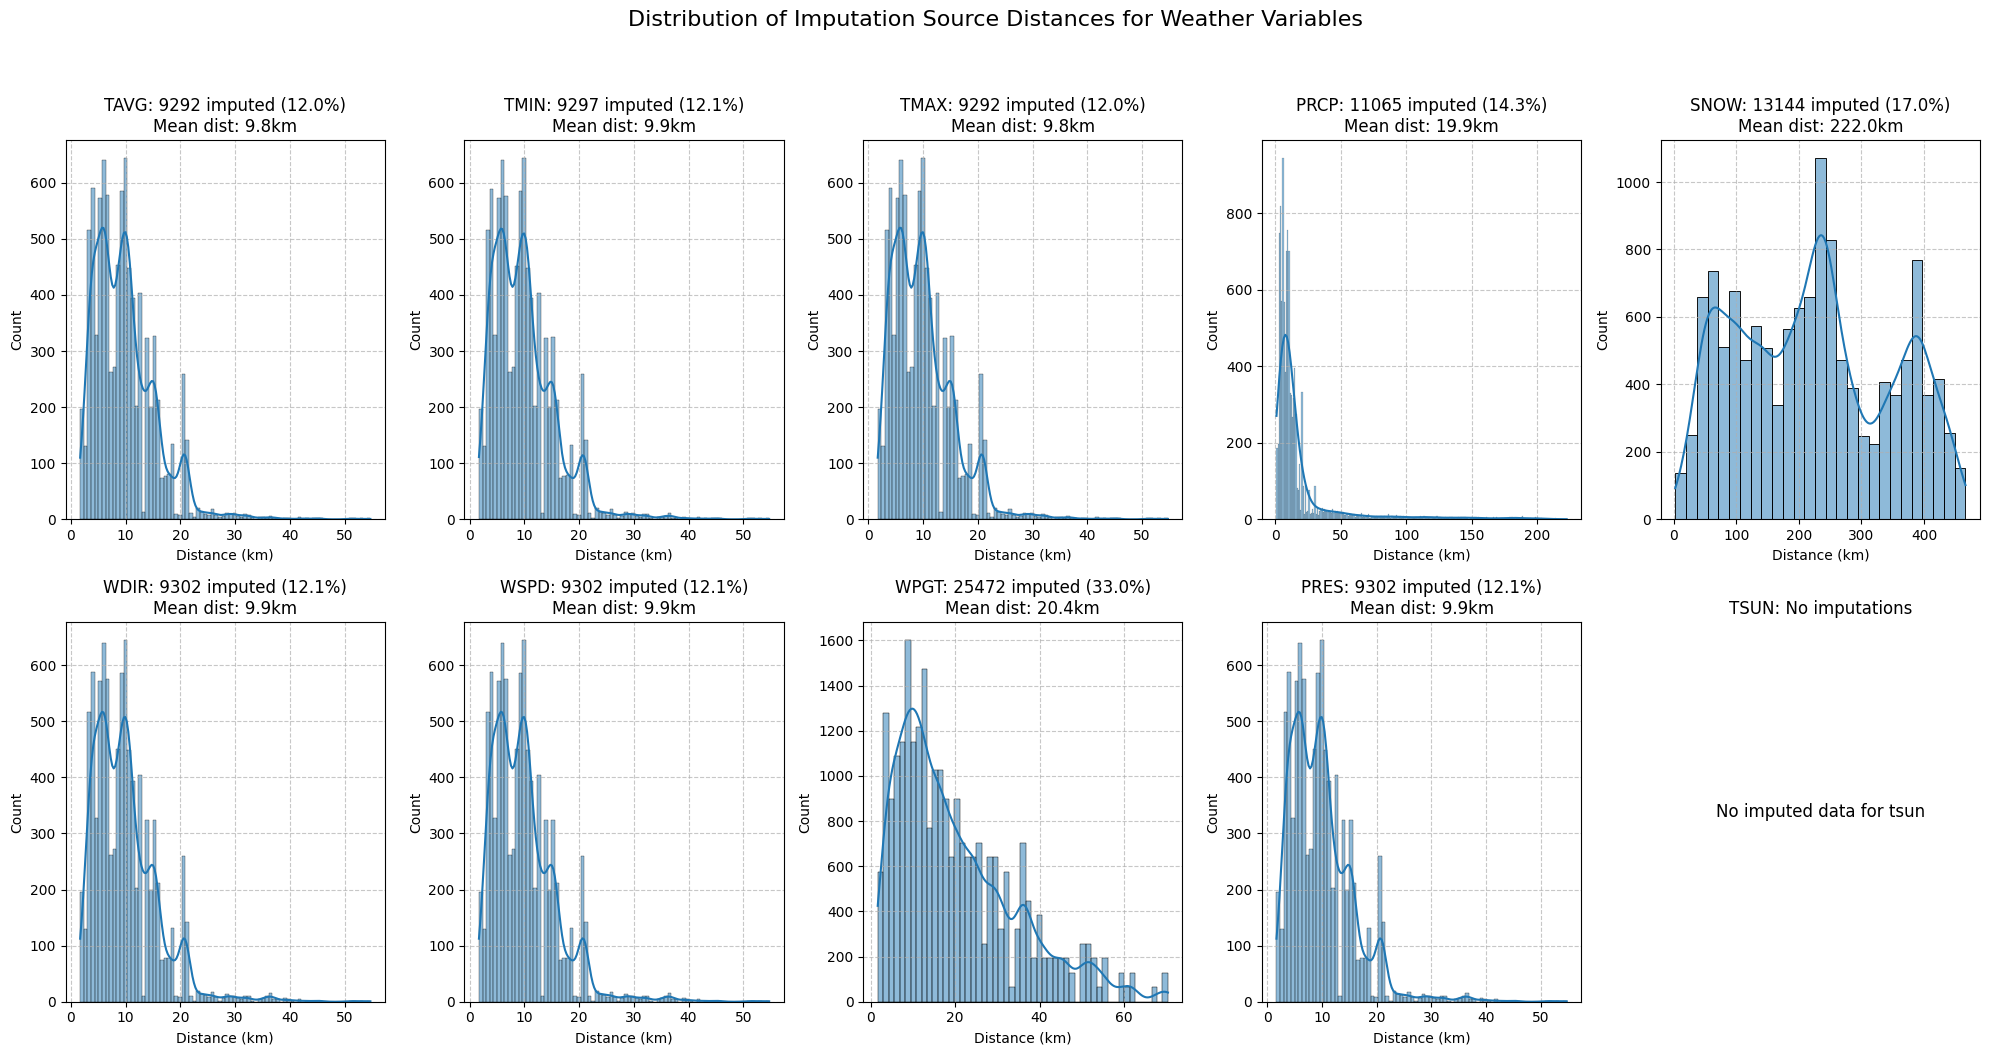

In [79]:
# Histogram of number of inputations by distance.
# Define the weather variables
weather_vars = [
    "tavg",
    "tmin",
    "tmax",
    "prcp",
    "snow",
    "wdir",
    "wspd",
    "wpgt",
    "pres",
    "tsun",
]

# Calculate the number of rows needed for 2 columns
num_vars = len(weather_vars)
num_rows = 2
num_cols = (num_vars + num_rows - 1) // num_rows  # This ensures enough cols

# Create a grid of subplots with 2 columns and calculated rows
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
axs = axs.flatten()

# Loop through each weather variable
for i, var in enumerate(weather_vars):
    # Get the column names for filtering and plotting
    was_imputed_col = f"{var}_was_imputed"
    dist_col = f"{var}_impute_source_dist"

    # Filter the dataframe where this variable was imputed
    imputed_df = df[df[was_imputed_col]]

    # Create the histogram with KDE in the corresponding subplot
    if not imputed_df.empty and dist_col in imputed_df.columns:
        sns.histplot(data=imputed_df, x=dist_col, kde=True, ax=axs[i])

        # Calculate statistics for title
        count = len(imputed_df)
        pct = 100 * count / len(df)
        mean_dist = imputed_df[dist_col].mean()

        # Add labels and title
        axs[i].set_title(
            f"{var.upper()}: {count} imputed ({pct:.1f}%)\nMean dist: {mean_dist:.1f}km"
        )
        axs[i].set_xlabel("Distance (km)")
        axs[i].set_ylabel("Count")
        axs[i].grid(True, linestyle="--", alpha=0.7)
    else:
        axs[i].text(
            0.5,
            0.5,
            f"No imputed data for {var}",
            ha="center",
            va="center",
            fontsize=12,
        )
        axs[i].set_title(f"{var.upper()}: No imputations")
        axs[i].axis("off")

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

# Add an overall title
plt.suptitle(
    "Distribution of Imputation Source Distances for Weather Variables",
    fontsize=16,
    y=1.05,
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

Snow looks very unordinary. 

In [80]:
df[weather_vars].describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,77120.000000,77120.000000,77120.000000,77120.000000,13255.000000,77120.000000,77120.000000,77120.000000,77120.000000,0.0
mean,1.825651,-1.051989,5.214558,0.584760,17.185213,181.573911,9.643146,34.528571,1024.329405,NaN
std,3.332749,3.068297,4.277466,1.671386,11.772805,94.645077,6.499236,14.338858,9.465027,NaN
min,-6.200000,-10.200000,-4.400000,0.000000,10.000000,0.000000,0.000000,7.000000,1002.400000,NaN
25%,-0.500000,-3.100000,2.000000,0.000000,10.000000,113.000000,4.800000,24.100000,1016.600000,NaN
50%,1.000000,-1.400000,4.900000,0.000000,10.000000,184.000000,8.100000,35.200000,1025.600000,NaN
75%,3.600000,0.500000,7.800000,0.100000,20.000000,259.000000,13.000000,42.600000,1032.200000,NaN
max,14.300000,11.000000,18.800000,19.500000,41.000000,359.000000,49.700000,90.000000,1042.900000,NaN


Snow seems to still have a lot of missing values. However, 0 is not in the range. Hence, 0 must be encoded with missing.
Solution:
- define a cutoff inputation distance, drop anything outside of it
- fill all missing with 0

In [81]:
# let's say that we can define a cutoff of 50 km for snow imputation. The distance metric is in kilometers, and is 0 if no imputatuion occured
# inputation happened by day and only if there was any non-missing observation then.
# precipitation and snow are highly correlated, and precipitation seems to be inputed mostly below 50 kms
# all missing then should be filled with 0 after the nan operation
df.loc[df["snow_impute_source_dist"] > 50, "snow"] = np.nan
df["snow"] = df["snow"].fillna(0)

REMOVED
We also want to limit spillover effects from distant rain measurements.
to the precipitation variable. We can use the same 50 km cutoff.
Since daily coverage is quite high for precipitation,
we can use daily averages to impute missing values. (0 is included in the range of values, so missing does not mean either zero or missing)

In [82]:
# df.loc[df["prcp_impute_source_dist"] > 50, "prcp"] = np.nan
# # Calculate daily averages for prcp - filtered from too distant measurements
# # Average is calculated for each day over all stops
# daily_avg_prcp = df.groupby(df["date"].dt.date)["prcp"].transform("mean")
# # Impute missing values in prcp with daily averages
# df["prcp"].fillna(daily_avg_prcp, inplace=True)


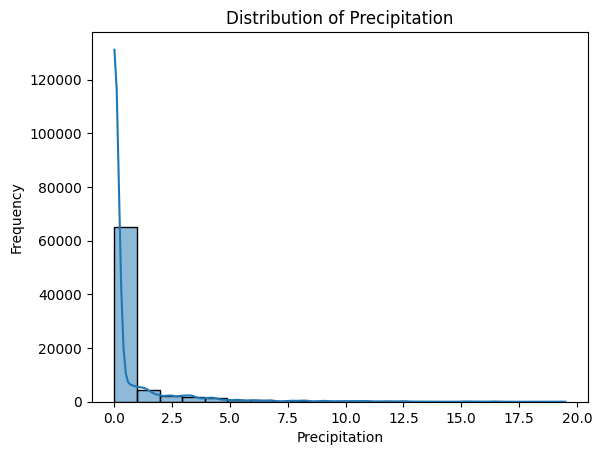

In [83]:
sns.histplot(df["prcp"], kde=True, bins=20)
plt.xlabel("Precipitation")
plt.ylabel("Frequency")
plt.title("Distribution of Precipitation")
plt.show()

In [84]:
# Generating categorical variables of precipitation in a more-than manner
# Define precipitation thresholds in mm
prcp_thresholds = [0, 0.1, 0.5, 1, 2, 5, 10, 15]
snow_thresholds = [0, 0.1, 10, 20, 40]

# Create categorical variables for precipitation
for threshold in prcp_thresholds:
    col_name = f"prcp_{threshold}_plus"
    df[col_name] = (df["prcp"] >= threshold).astype(int)

# Create a table of counts for each precipitation threshold
prcp_counts = (
    df[[f"prcp_{threshold}_plus" for threshold in prcp_thresholds]].sum().reset_index()
)
prcp_counts.columns = ["Threshold", "Count"]
prcp_counts["Threshold"] = (
    prcp_counts["Threshold"]
    .str.replace("prcp_", "")
    .str.replace("_plus", "")
    .astype(float)
)
prcp_counts = prcp_counts.sort_values(by="Threshold").reset_index(drop=True)
print(prcp_counts)

# Create categorical variables for snow
for threshold in snow_thresholds:
    col_name = f"snow_{threshold}_plus"
    df[col_name] = (df["snow"] >= threshold).astype(int)

# Create a table of counts for each snow threshold
snow_counts = (
    df[[f"snow_{threshold}_plus" for threshold in snow_thresholds]].sum().reset_index()
)
snow_counts.columns = ["Threshold", "Count"]
snow_counts["Threshold"] = (
    snow_counts["Threshold"]
    .str.replace("snow_", "")
    .str.replace("_plus", "")
    .astype(float)
)
snow_counts = snow_counts.sort_values(by="Threshold").reset_index(drop=True)
print(snow_counts)


   Threshold  Count
0        0.0  77120
1        0.1  20446
2        0.5  14852
3        1.0  11862
4        2.0   7500
5        5.0   2316
6       10.0    545
7       15.0    110
   Threshold  Count
0        0.0  77120
1        0.1   1011
2       10.0   1011
3       20.0    320
4       40.0    106


In [85]:
import plotly.express as px
import plotly.graph_objects as go

# Convert date column to datetime if necessary
df["date"] = pd.to_datetime(df["date"])

# Calculate daily averages
daily_avg_precipitation = df.groupby(df["date"].dt.date)["prcp"].mean().reset_index()
daily_avg_precipitation["date"] = pd.to_datetime(daily_avg_precipitation["date"])

daily_avg_delay = (
    df.groupby(df["date"].dt.date)["avg_incoming_delay"].mean().reset_index()
)
daily_avg_delay["date"] = pd.to_datetime(daily_avg_delay["date"])

daily_avg_snow = df.groupby(df["date"].dt.date)["snow"].mean().reset_index()
daily_avg_snow["date"] = pd.to_datetime(daily_avg_snow["date"])

# Create the first figure for Precipitation & Train Delays
fig = go.Figure()

# Add precipitation trace
fig.add_trace(
    go.Scatter(
        x=daily_avg_precipitation["date"],
        y=daily_avg_precipitation["prcp"],
        mode="lines",
        name="Average Daily Precipitation",
        line=dict(color="blue"),
        yaxis="y",
    )
)

# Add snow trace
fig.add_trace(
    go.Scatter(
        x=daily_avg_snow["date"],
        y=daily_avg_snow["snow"],
        mode="lines",
        name="Average Daily Snow",
        line=dict(color="purple"),
        yaxis="y",
    )
)

# Add train delay trace
fig.add_trace(
    go.Scatter(
        x=daily_avg_delay["date"],
        y=daily_avg_delay["avg_incoming_delay"],
        mode="lines",
        name="Average Daily Delay",
        line=dict(color="orange"),
        yaxis="y2",
    )
)

# Update layout
fig.update_layout(
    title="Weather Factors and Train Delays",
    xaxis=dict(title="Date", tickangle=45),
    yaxis=dict(title="Precipitation & Snow (mm)", side="left"),
    yaxis2=dict(title="Average Daily Delay (minutes)", overlaying="y", side="right"),
    legend=dict(x=0, y=1),
    template="plotly_white",
)

# Show the figure
fig.show()

# Save the figure to an HTML file
fig.write_html("weather_factors_and_train_delays.html")


## Graph Metrics Preprocessing

In [86]:
def calculate_ratios(df, incoming_delayed_counts, number_of_incoming_trains_col):
    for col in incoming_delayed_counts:
        avg_col_name = f"{col}_ratio"
        df[avg_col_name] = np.where(
            df[number_of_incoming_trains_col] != 0,
            df[col] / df[number_of_incoming_trains_col],
            0,
        )
    return df


# Define the columns to normalize and the column indicating the number of incoming trains
incoming_delayed_counts_to_normalize = [
    "incoming_1_plus",
    "incoming_15_plus",
    "incoming_30_plus",
    "incoming_60_plus",
    "incoming_120_plus",
]
number_of_incoming_trains = "incoming"

# Calculate the average number of incoming trains for each of the delayed counts
df = calculate_ratios(
    df, incoming_delayed_counts_to_normalize, number_of_incoming_trains
)

incoming_delay_category_ratios = [
    f"{col}_ratio" for col in incoming_delayed_counts_to_normalize
]
df[incoming_delay_category_ratios].describe()

# Display the first few rows to verify the new columns
df[incoming_delay_category_ratios].sample(500)


,incoming_1_plus_ratio,incoming_15_plus_ratio,incoming_30_plus_ratio,incoming_60_plus_ratio,incoming_120_plus_ratio
60519,0.471698,0.000000,0.000000,0.000000,0.000000
57080,0.000000,0.000000,0.000000,0.000000,0.000000
78965,0.000000,0.000000,0.000000,0.000000,0.000000
47881,0.500000,0.000000,0.000000,0.000000,0.000000
74887,0.722222,0.111111,0.111111,0.111111,0.111111
...,...,...,...,...,...
72312,0.500000,0.000000,0.000000,0.000000,0.000000
29682,0.333333,0.333333,0.333333,0.333333,0.333333
34596,0.918367,0.204082,0.000000,0.000000,0.000000
66801,0.411765,0.058824,0.058824,0.058824,0.058824


**Potential for DiD?**
- For that, we would need to compare two weeks, one where it rained nowhere, and another, where it rained for a subsection of the stops, but not everywhere.
- It would still be not straightforward.
  - Inherently, there is a strong spillover effect due to the network nature of the data source. If a train is delayed somewhere, it will cause delays somewhere else too.

**What to do then?**
- We go with descriptive analytics and include a cross-sectional analysis (for selected weeks) for an overview and then go to analyze the time-series

# Descriptive statistics

In [87]:
outcome_vars = [
    "avg_incoming_delay",
    "incoming_1_plus_ratio",
    "incoming_15_plus_ratio",
    "incoming_30_plus_ratio",
    "incoming_60_plus_ratio",
    "incoming_120_plus_ratio",
]

treatment_vars = [
    "prcp",
    "prcp_0.1_plus",
    "prcp_0.5_plus",
    "prcp_1_plus",
    "prcp_2_plus",
    "prcp_5_plus",
    "prcp_10_plus",
    "prcp_15_plus",
    "snow",  # one of the following values [ 0, 10, 20, 41]
]

confounders = [
    "incoming_distance_strength",
    "incoming_time_strength",
    "incoming_speed_strength",
    "weighted_betweenness",
    "weighted_closeness",
    "tavg",
    "tmin",
    "tmax",
    "wdir",
    "wspd",
    "wpgt",
    "pres",
    "tsun",
]

## What are our variables in question?
### Outcome - Delay of arriving trains
- Either measured as the average of all incoming trains (minutes), or the ratio of the incoming trains above a certain threshold of delay to all incoming trains.
### Causal - Precipitation OR snow
- Either measured continuously (mm), or as a boolean with different cutoffs
  - e.g. if prcp_0.5_plus is True, that indicates that on that day at that - or a nearby - stop more rain fell than 0.5 mm
### Potential Confounders - Other weather variables and graph variables
- For this assignment, we choose only the weighted_betweenness

| **Variable Name**             | **Category**       | **Description** |
|------------------------------|-------------------|----------------|
| `incoming_distance_strength` | Graph Metric     | Total distance incoming trains have to travel from neighboring stations. |
| `incoming_time_strength`     | Graph Metric     | Total travel time of incoming trains from neighboring stations. |
| `incoming_speed_strength`    | Graph Metric     | Average speed of incoming trains from neighboring stations. |
| `weighted_betweenness`       | Graph Metric     | Betweenness centrality weighted by train traffic. |
| `weighted_closeness`         | Graph Metric     | Closeness centrality weighted by train traffic. |
| `tavg`                       | Weather Variable | Average temperature from meteodata. |
| `tmin`                       | Weather Variable | Minimum temperature from meteodata. |
| `tmax`                       | Weather Variable | Maximum temperature from meteodata. |
| `wdir`                       | Weather Variable | Wind direction from meteodata. |
| `wspd`                       | Weather Variable | Wind speed from meteodata. |
| `wpgt`                       | Weather Variable | Wind gust speed from meteodata. |
| `pres`                       | Weather Variable | Atmospheric pressure from meteodata. |
| `tsun`                       | Weather Variable | Sunshine duration from meteodata. |




## Describing the important features

### The outcome variable

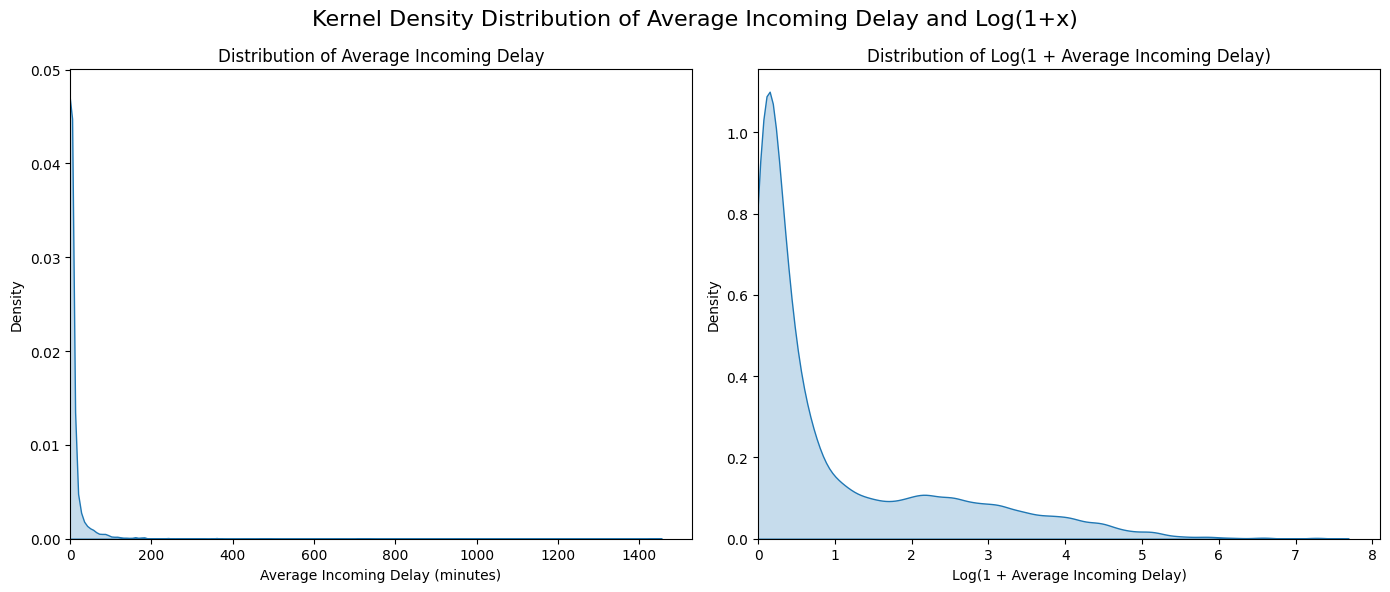

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Original distribution
sns.kdeplot(df["avg_incoming_delay"], fill=True, ax=axs[0])
axs[0].set_xlabel("Average Incoming Delay (minutes)")
axs[0].set_ylabel("Density")
axs[0].set_title("Distribution of Average Incoming Delay")
axs[0].set_xlim(left=0)

# Log-transformed distribution
sns.kdeplot(np.log1p(df["avg_incoming_delay"]), fill=True, ax=axs[1])
axs[1].set_xlabel("Log(1 + Average Incoming Delay)")
axs[1].set_ylabel("Density")
axs[1].set_title("Distribution of Log(1 + Average Incoming Delay)")
axs[1].set_xlim(left=0)

# Add an overall title
fig.suptitle(
    "Kernel Density Distribution of Average Incoming Delay and Log(1+x)", fontsize=16
)

plt.tight_layout()
plt.show()

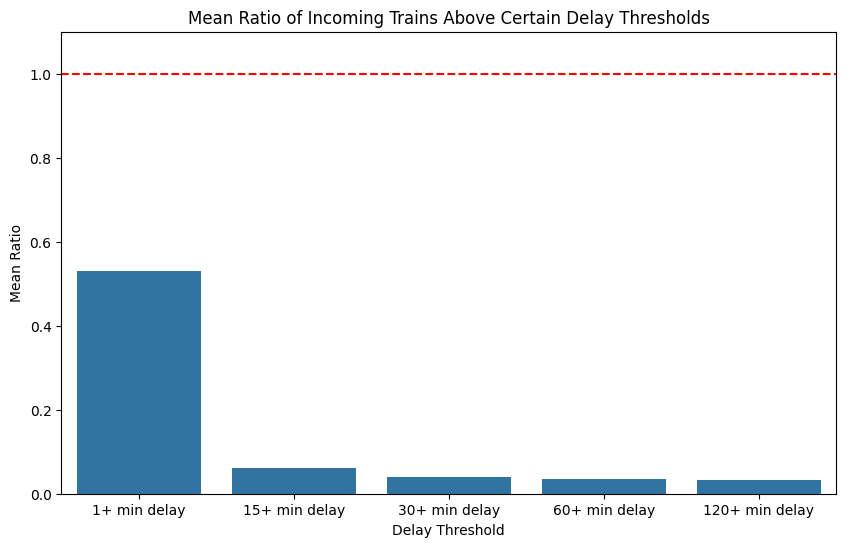

In [89]:
# Define the ratios and their labels
ratios = [
    "incoming_1_plus_ratio",
    "incoming_15_plus_ratio",
    "incoming_30_plus_ratio",
    "incoming_60_plus_ratio",
    "incoming_120_plus_ratio",
]
labels = [
    "1+ min delay",
    "15+ min delay",
    "30+ min delay",
    "60+ min delay",
    "120+ min delay",
]

# Calculate the mean of each ratio
mean_ratios = df[ratios].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=mean_ratios)
plt.axhline(y=1, color="r", linestyle="--")
plt.ylim(0, 1.1)
plt.xlabel("Delay Threshold")
plt.ylabel("Mean Ratio")
plt.title("Mean Ratio of Incoming Trains Above Certain Delay Thresholds")
plt.show()

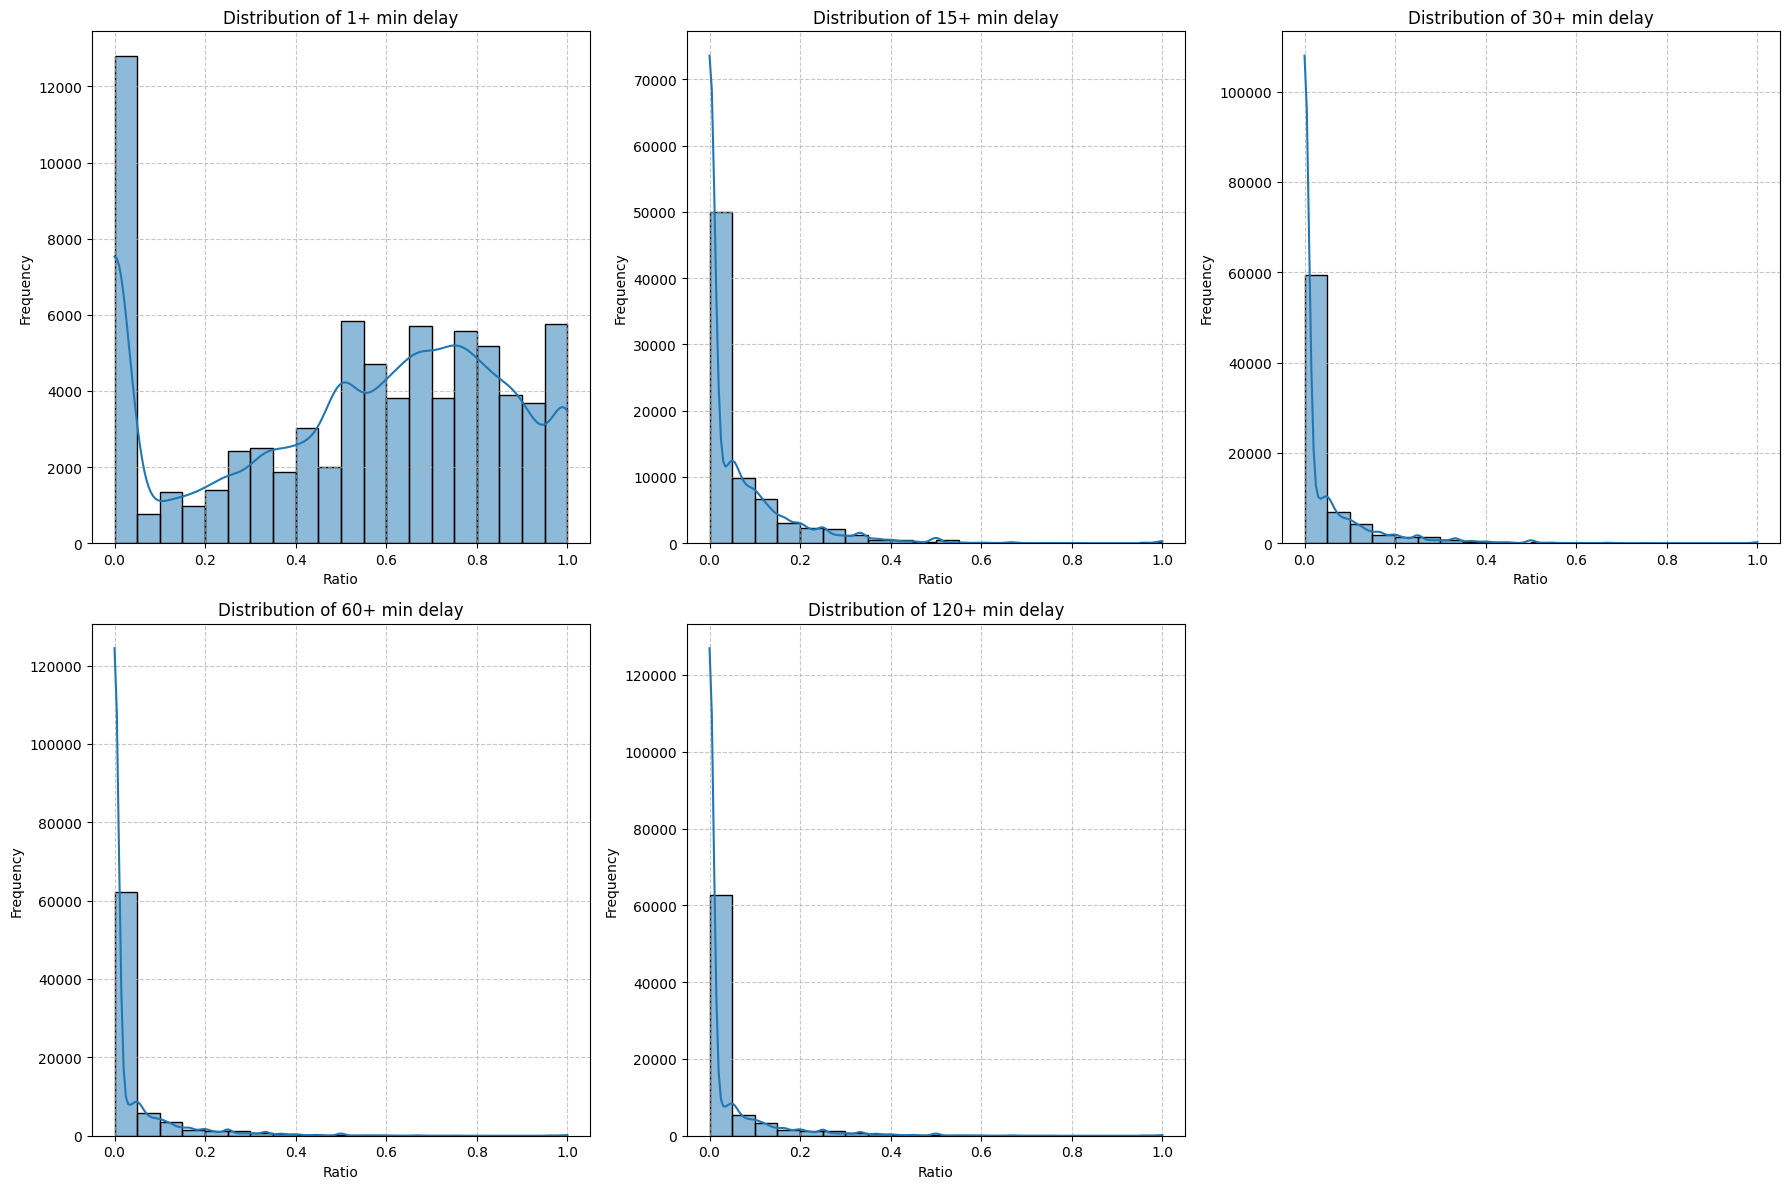

In [90]:
# Define the ratios and their labels
ratios = [
    "incoming_1_plus_ratio",
    "incoming_15_plus_ratio",
    "incoming_30_plus_ratio",
    "incoming_60_plus_ratio",
    "incoming_120_plus_ratio",
]
labels = [
    "1+ min delay",
    "15+ min delay",
    "30+ min delay",
    "60+ min delay",
    "120+ min delay",
]

# Calculate the number of rows and columns for the grid
num_rows = 2
num_cols = 3

# Create a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 12))
axs = axs.flatten()

# Loop through each ratio and plot its distribution
for i, ratio in enumerate(ratios):
    sns.histplot(df[ratio], kde=True, ax=axs[i], bins=20)
    axs[i].set_title(f"Distribution of {labels[i]}")
    axs[i].set_xlabel("Ratio")
    axs[i].set_ylabel("Frequency")
    axs[i].grid(True, linestyle="--", alpha=0.7)

# Hide any unused subplots
for j in range(len(ratios), len(axs)):
    axs[j].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

Our analysis will face the problem of strong non-linearity, with neither normal, nor log-normal distributions observed in our key dependent or confounding variables. This would be solved in the literature with a number of methods, including leveraging link functions and combining probabilistic regressions to compute the probability of arriving on time and 

### The causal variable
- Precipitation mainly
- Snow could be checked

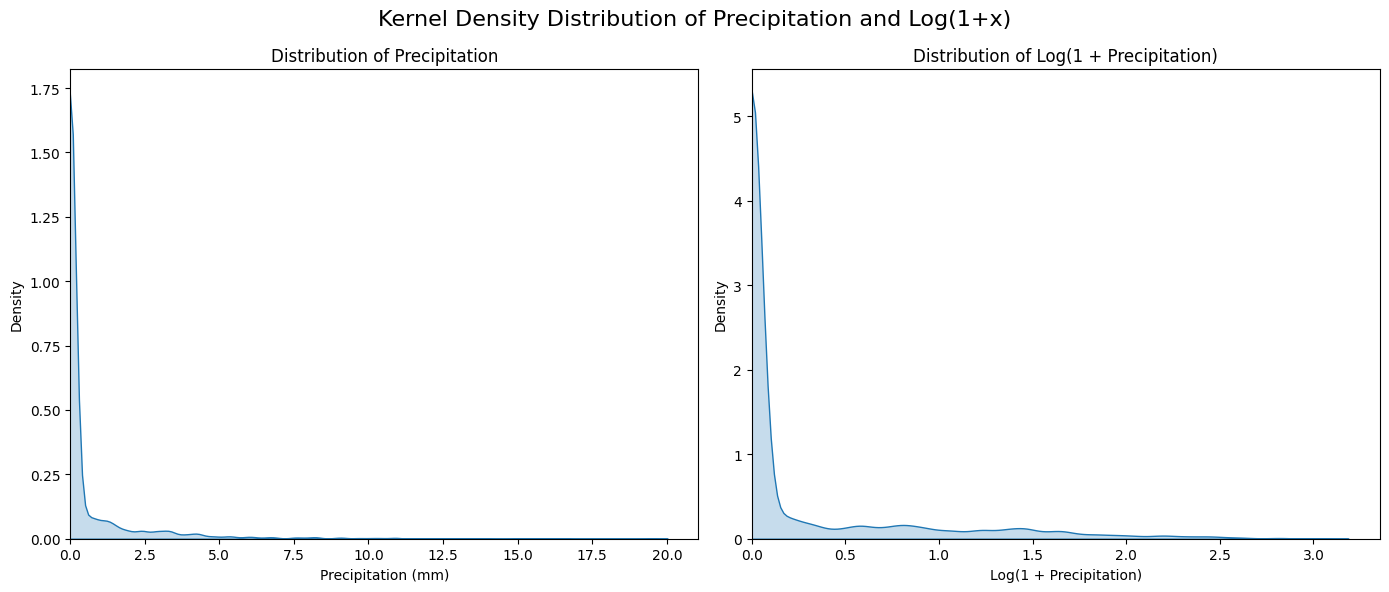

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Original distribution
sns.kdeplot(df["prcp"], fill=True, ax=axs[0])
axs[0].set_xlabel("Precipitation (mm)")
axs[0].set_ylabel("Density")
axs[0].set_title("Distribution of Precipitation")
axs[0].set_xlim(left=0)

# Log-transformed distribution
sns.kdeplot(np.log1p(df["prcp"]), fill=True, ax=axs[1])
axs[1].set_xlabel("Log(1 + Precipitation)")
axs[1].set_ylabel("Density")
axs[1].set_title("Distribution of Log(1 + Precipitation)")
axs[1].set_xlim(left=0)

# Add an overall title
fig.suptitle("Kernel Density Distribution of Precipitation and Log(1+x)", fontsize=16)

plt.tight_layout()
plt.show()

Precipitation is possibly power-law.

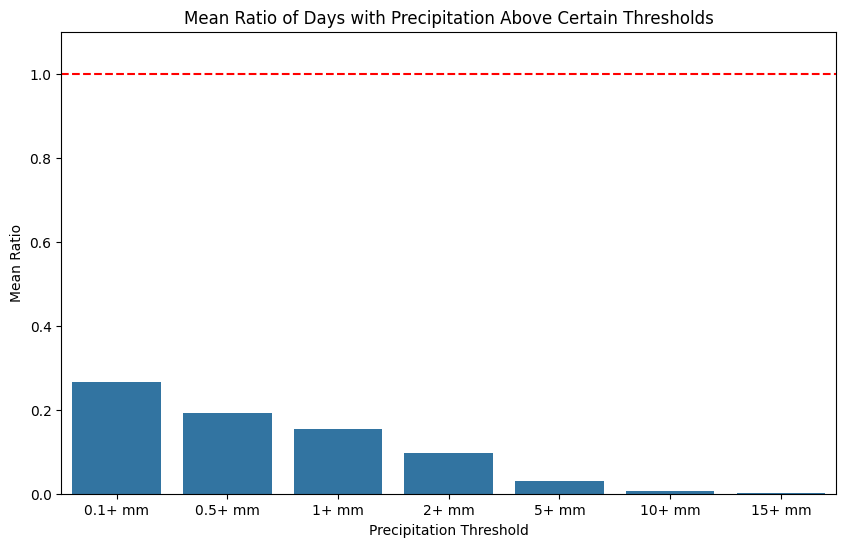

In [92]:
# Define the precipitation categories and their labels
prcp_categories = [
    "prcp_0.1_plus",
    "prcp_0.5_plus",
    "prcp_1_plus",
    "prcp_2_plus",
    "prcp_5_plus",
    "prcp_10_plus",
    "prcp_15_plus",
]
labels = [
    "0.1+ mm",
    "0.5+ mm",
    "1+ mm",
    "2+ mm",
    "5+ mm",
    "10+ mm",
    "15+ mm",
]

# Calculate the mean of each precipitation category
mean_prcp_categories = df[prcp_categories].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=mean_prcp_categories)
plt.axhline(y=1, color="r", linestyle="--")
plt.ylim(0, 1.1)
plt.xlabel("Precipitation Threshold")
plt.ylabel("Mean Ratio")
plt.title("Mean Ratio of Days with Precipitation Above Certain Thresholds")
plt.show()

In [93]:
df["snow"].value_counts()

snow
0.0     76109
10.0      691
20.0      214
41.0      106
Name: count, dtype: int64

In [94]:
df["any_snow"] = df["snow"] > 0
df["any_snow"].value_counts()

any_snow
False    76109
True      1011
Name: count, dtype: int64

### The confounding variable

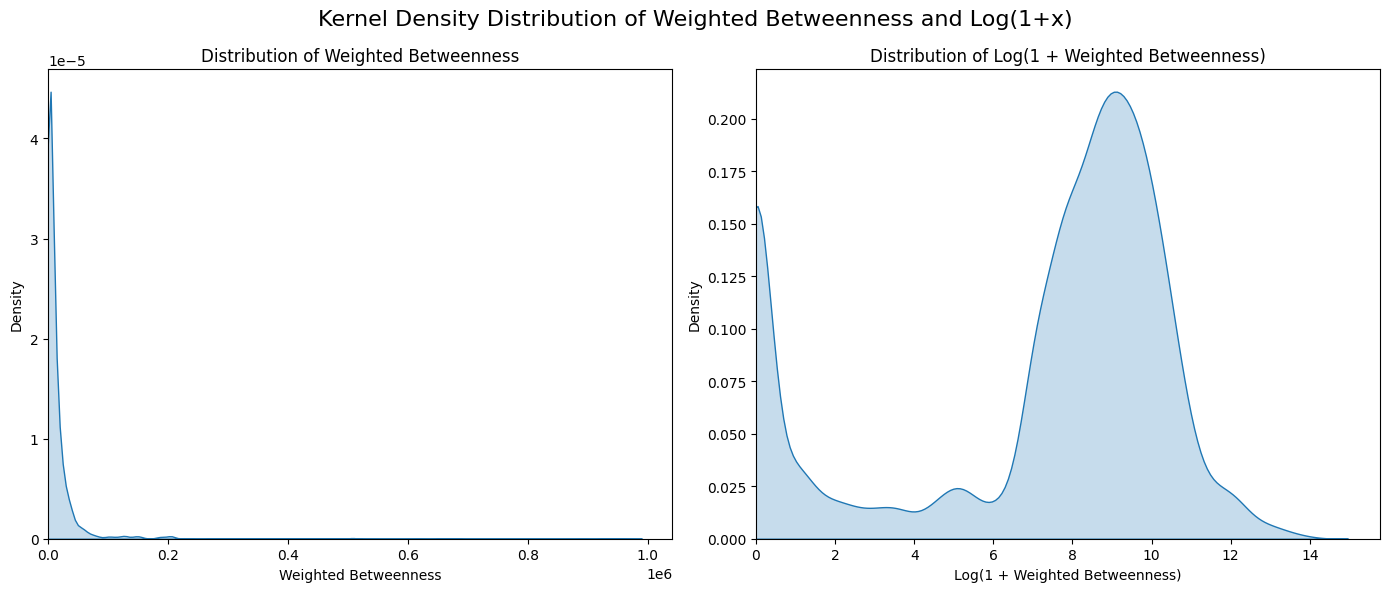

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Original distribution
sns.kdeplot(df["weighted_betweenness"], fill=True, ax=axs[0])
axs[0].set_xlabel("Weighted Betweenness")
axs[0].set_ylabel("Density")
axs[0].set_title("Distribution of Weighted Betweenness")
axs[0].set_xlim(left=0)

# Log-transformed distribution
sns.kdeplot(np.log1p(df["weighted_betweenness"]), fill=True, ax=axs[1])
axs[1].set_xlabel("Log(1 + Weighted Betweenness)")
axs[1].set_ylabel("Density")
axs[1].set_title("Distribution of Log(1 + Weighted Betweenness)")
axs[1].set_xlim(left=0)

# Add an overall title
fig.suptitle(
    "Kernel Density Distribution of Weighted Betweenness and Log(1+x)", fontsize=16
)
plt.tight_layout()
plt.show()

- For this confounder, we will go with the logarithm, it looks quite alright

### General relationship between the cofounder and the causal over all days in the window of observation

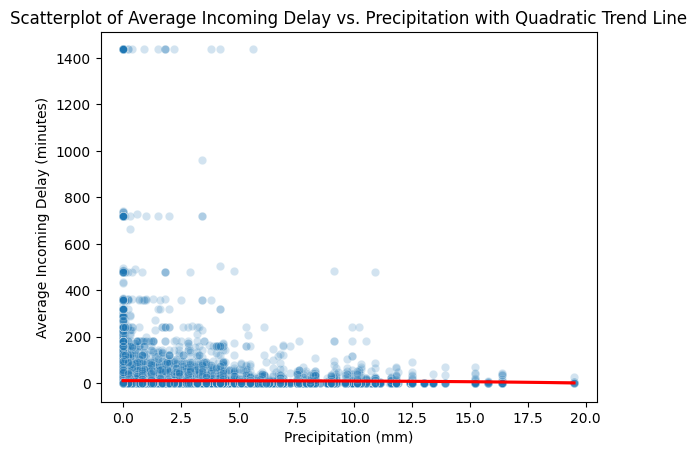

In [96]:
sns.scatterplot(data=df, x="prcp", y="avg_incoming_delay", alpha=0.2)
sns.regplot(
    data=df, x="prcp", y="avg_incoming_delay", scatter=False, order=3, color="red"
)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Average Incoming Delay (minutes)")
plt.title(
    "Scatterplot of Average Incoming Delay vs. Precipitation with Quadratic Trend Line"
)
plt.show()

Lambda for avg_incoming_delay: -0.7612024349275028
Lambda for prcp: -3.4422324522013166


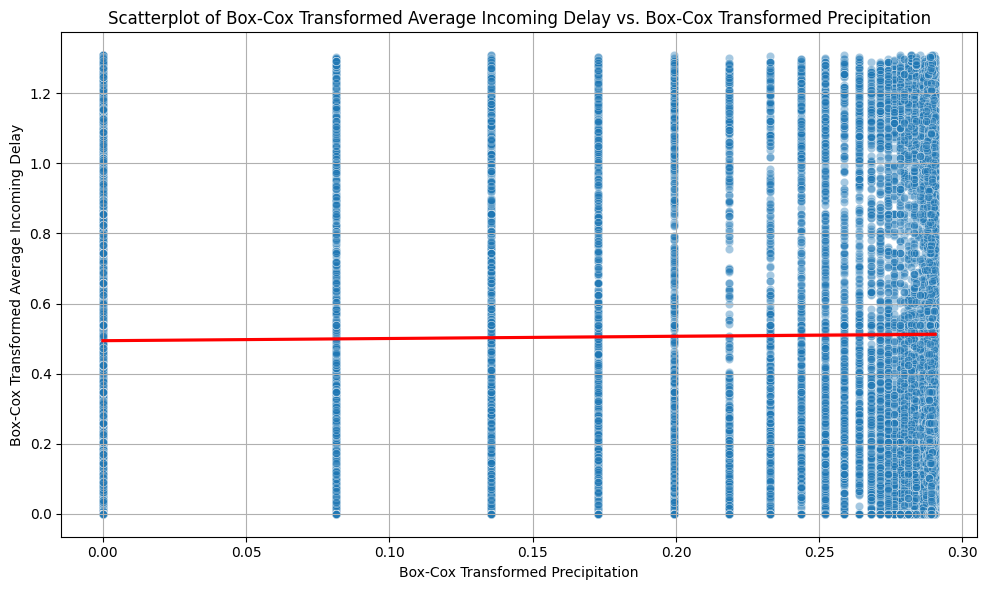

In [97]:
from scipy.stats import boxcox
import seaborn as sns

import matplotlib.pyplot as plt

# Create a copy of the dataframe
df_boxcox = df.copy()

# Drop rows with NaNs in avg_incoming_delay and prcp to make Box-Cox transformation feasible
df_boxcox = df_boxcox[["avg_incoming_delay", "prcp"]].dropna()

# Perform Box-Cox transformation on avg_incoming_delay and prcp
df_boxcox["boxcox_avg_incoming_delay"], lambda_delay = boxcox(
    df_boxcox["avg_incoming_delay"] + 1
)  # Adding 1 to avoid zero values
df_boxcox["boxcox_prcp"], lambda_prcp = boxcox(
    df_boxcox["prcp"] + 1
)  # Adding 1 to avoid zero values

# Print the lambda values
print(f"Lambda for avg_incoming_delay: {lambda_delay}")
print(f"Lambda for prcp: {lambda_prcp}")

# Create the scatterplot with a fitted linear line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_boxcox, x="boxcox_prcp", y="boxcox_avg_incoming_delay", alpha=0.4
)
sns.regplot(
    data=df_boxcox,
    x="boxcox_prcp",
    y="boxcox_avg_incoming_delay",
    scatter=False,
    color="red",
)
plt.xlabel("Box-Cox Transformed Precipitation")
plt.ylabel("Box-Cox Transformed Average Incoming Delay")
plt.title(
    "Scatterplot of Box-Cox Transformed Average Incoming Delay vs. Box-Cox Transformed Precipitation"
)
plt.grid(True)
plt.tight_layout()
plt.show()

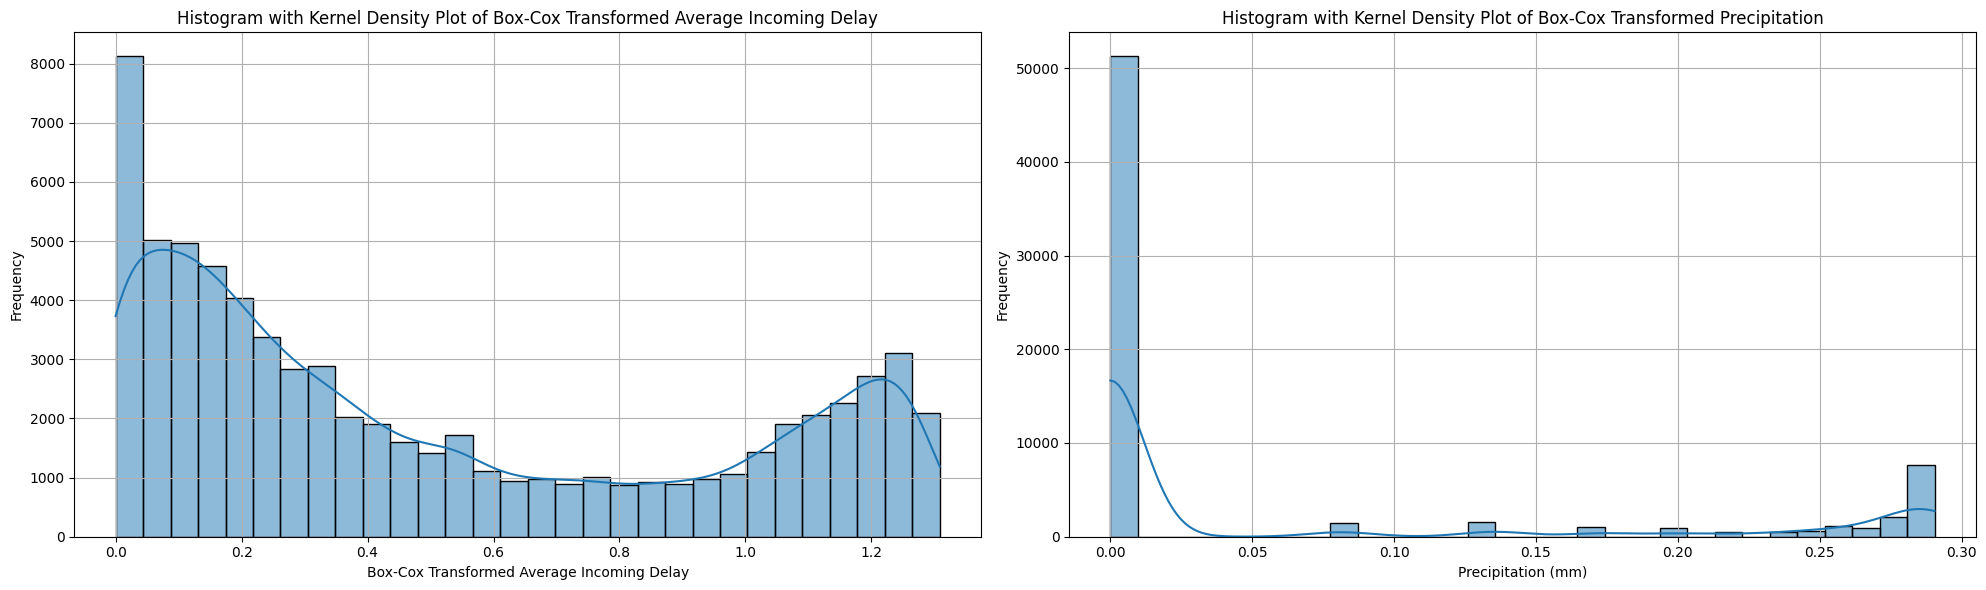

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Histogram with Kernel Density Plot of Box-Cox Transformed Average Incoming Delay
sns.histplot(df_boxcox["boxcox_avg_incoming_delay"], kde=True, bins=30, ax=axs[0])
axs[0].set_xlabel("Box-Cox Transformed Average Incoming Delay")
axs[0].set_ylabel("Frequency")
axs[0].set_title(
    "Histogram with Kernel Density Plot of Box-Cox Transformed Average Incoming Delay"
)
axs[0].grid(True)

# Histogram with Kernel Density Plot of Precipitation
sns.histplot(df_boxcox["boxcox_prcp"], kde=True, bins=30, ax=axs[1])
axs[1].set_xlabel("Precipitation (mm)")
axs[1].set_ylabel("Frequency")
axs[1].set_title(
    "Histogram with Kernel Density Plot of Box-Cox Transformed Precipitation"
)
axs[1].grid(True)

plt.tight_layout()
plt.show()

Even the box-cox transformation returns a left-skewed, and not normally distributed, or unimodal, symmetric distribution to these two variables.
- This shows that we will have a difficult time in trying to find a linear, or closely-linear connection between the features. As we have seen before, our distributions are very heavily left skewed with lots of 0 values.
- It would make sense, to instead look at the probability of a delay with a certain strictness given there is any rain above a certain threshold.
- To analyze this, I introduce the pairwise correlations of the ratio of trains arriving with a delay of at least a certain number and of whether precipitation exceeds a certain threshold 

Can we find any correlation between the causal and outcome?

Within-day, we can see, that there is hardly any relationship between incoming delays and precipitation, and if so, it is negative.

In [99]:
# Define the precipitation and incoming delay ratio variables
prcp_vars = [f"prcp_{threshold}_plus" for threshold in prcp_thresholds]
incoming_vars = [
    f"incoming_{threshold}_plus_ratio" for threshold in [1, 15, 30, 60, 120]
]

# Filter the dataframe to only include a specific date with higher-than-usual precipitation and incoming delays
filtered_df = df[(df["date"] == "2025-01-28")]

# Calculate the correlation matrix
correlation_matrix_prcp_incoming = (
    filtered_df[prcp_vars + incoming_vars].corr().loc[prcp_vars, incoming_vars].round(2)
)
correlation_matrix_prcp_incoming

,incoming_1_plus_ratio,incoming_15_plus_ratio,incoming_30_plus_ratio,incoming_60_plus_ratio,incoming_120_plus_ratio
prcp_0_plus,NaN,NaN,NaN,NaN,NaN
prcp_0.1_plus,0.02,-0.08,-0.08,-0.02,-0.02
prcp_0.5_plus,0.02,0.00,0.01,0.02,0.02
prcp_1_plus,0.05,0.01,0.01,0.01,0.01
prcp_2_plus,0.06,-0.05,-0.04,-0.02,-0.02
prcp_5_plus,0.02,-0.04,-0.04,-0.04,-0.04
prcp_10_plus,-0.03,-0.03,-0.03,-0.03,-0.03
prcp_15_plus,NaN,NaN,NaN,NaN,NaN


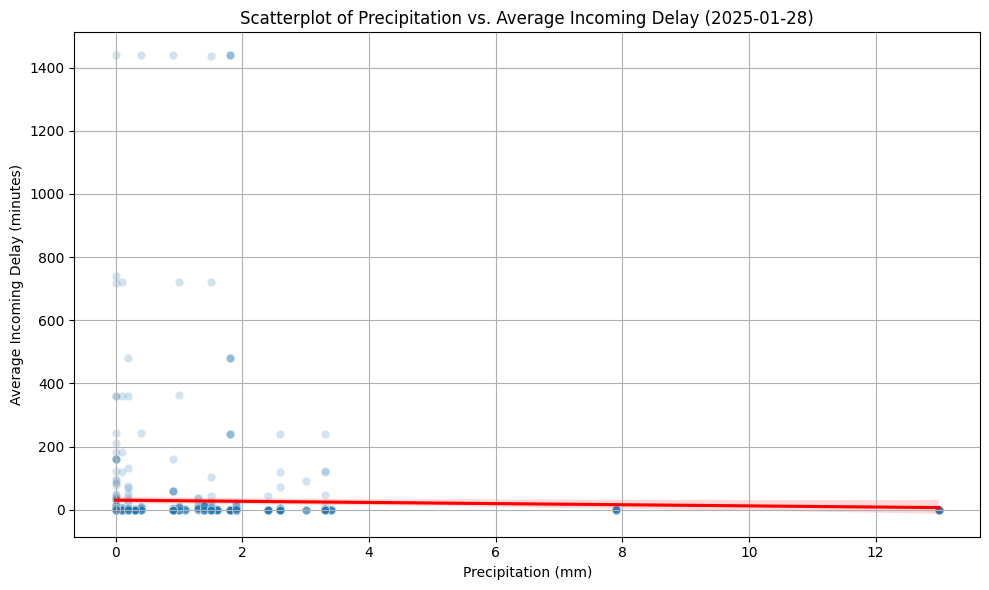

In [100]:
# Filter the data for the specified date range
filtered_df = df[(df["date"] == "2025-01-28")]

# Create the scatterplot
plt.figure(figsize=(10, 6))

# Original scatterplot
sns.scatterplot(data=filtered_df, x="prcp", y="avg_incoming_delay", alpha=0.2)
sns.regplot(
    data=filtered_df,
    x="prcp",
    y="avg_incoming_delay",
    scatter=False,
    color="red",
)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Average Incoming Delay (minutes)")
plt.title("Scatterplot of Precipitation vs. Average Incoming Delay (2025-01-28)")
plt.grid(True)

plt.tight_layout()
plt.show()


What if we consider the relationship over a week?

In [101]:
# Define the precipitation and incoming delay ratio variables
prcp_vars = [f"prcp_{threshold}_plus" for threshold in prcp_thresholds]
incoming_vars = [
    f"incoming_{threshold}_plus_ratio" for threshold in [1, 15, 30, 60, 120]
]

df_filtered = df[(df["date"] >= "2025-01-02") & (df["date"] <= "2025-01-10")]

# Calculate the correlation matrix
correlation_matrix_prcp_incoming = (
    df_filtered[prcp_vars + incoming_vars].corr().loc[prcp_vars, incoming_vars].round(2)
)
correlation_matrix_prcp_incoming

,incoming_1_plus_ratio,incoming_15_plus_ratio,incoming_30_plus_ratio,incoming_60_plus_ratio,incoming_120_plus_ratio
prcp_0_plus,NaN,NaN,NaN,NaN,NaN
prcp_0.1_plus,0.02,-0.00,0.01,0.00,0.00
prcp_0.5_plus,0.03,-0.01,-0.01,-0.02,-0.02
prcp_1_plus,0.04,-0.01,-0.02,-0.02,-0.02
prcp_2_plus,0.04,0.02,-0.01,-0.01,-0.01
prcp_5_plus,0.01,0.01,0.01,-0.00,-0.00
prcp_10_plus,0.04,0.01,-0.00,-0.01,-0.01
prcp_15_plus,0.03,-0.02,-0.01,-0.01,-0.01


In [102]:
# Define the snow and incoming delay ratio variables
snow_vars = [f"snow_{threshold}_plus" for threshold in snow_thresholds]
incoming_vars = [
    f"incoming_{threshold}_plus_ratio" for threshold in [1, 15, 30, 60, 120]
]

df_filtered = df[(df["date"] >= "2025-01-02") & (df["date"] <= "2025-01-10")]

# Calculate the correlation matrix
correlation_matrix_snow_incoming = (
    df_filtered[snow_vars + incoming_vars].corr().loc[snow_vars, incoming_vars].round(2)
)
correlation_matrix_snow_incoming

,incoming_1_plus_ratio,incoming_15_plus_ratio,incoming_30_plus_ratio,incoming_60_plus_ratio,incoming_120_plus_ratio
snow_0_plus,NaN,NaN,NaN,NaN,NaN
snow_0.1_plus,-0.00,0.00,-0.02,-0.02,-0.02
snow_10_plus,-0.00,0.00,-0.02,-0.02,-0.02
snow_20_plus,0.01,-0.02,-0.02,-0.02,-0.02
snow_40_plus,NaN,NaN,NaN,NaN,NaN


For a week with strong precipitation and not so strong delays, we can see a very minor positive correlation between precipitation and the probability of being late by more than 1 minute. This very weak correlation disappears for higher delay cutoffs.
Snow isn't correlating with delays either.

This could indicate a large scale of spillover effects, or a problem with the strong non-linearity of our variables. If precipitation causes a malfunction or delay somewhere, it could very quickly trickle down to other stops aswell.
What if we look at correlations over daily-level averages for the entire time horizon? A positive correlation could indicate that precipitation affects the system as a whole, as some kind of shock.

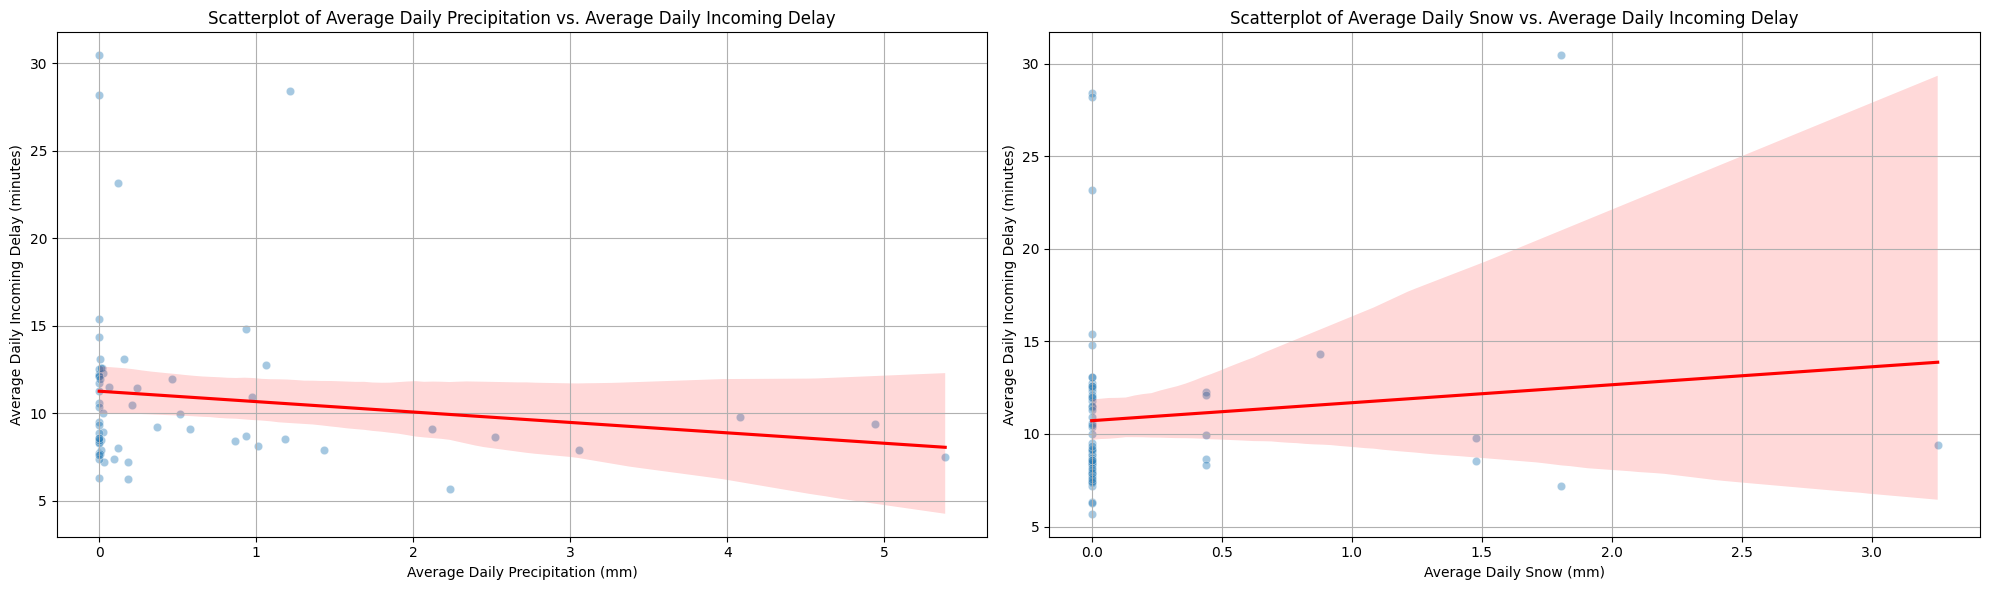

In [103]:
# Calculate daily averages
daily_avg = (
    df.groupby(df["date"].dt.date)
    .agg(
        avg_prcp=("prcp", "mean"),
        avg_snow=("snow", "mean"),
        avg_incoming_delay=("avg_incoming_delay", "mean"),
    )
    .reset_index()
)

# Create the scatterplots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Scatterplot for Precipitation
sns.scatterplot(
    data=daily_avg, x="avg_prcp", y="avg_incoming_delay", alpha=0.4, ax=axs[0]
)
sns.regplot(
    data=daily_avg,
    x="avg_prcp",
    y="avg_incoming_delay",
    scatter=False,
    color="red",
    ax=axs[0],
)
axs[0].set_xlabel("Average Daily Precipitation (mm)")
axs[0].set_ylabel("Average Daily Incoming Delay (minutes)")
axs[0].set_title(
    "Scatterplot of Average Daily Precipitation vs. Average Daily Incoming Delay"
)
axs[0].grid(True)

# Scatterplot for Snow
sns.scatterplot(
    data=daily_avg, x="avg_snow", y="avg_incoming_delay", alpha=0.4, ax=axs[1]
)
sns.regplot(
    data=daily_avg,
    x="avg_snow",
    y="avg_incoming_delay",
    scatter=False,
    color="red",
    ax=axs[1],
)
axs[1].set_xlabel("Average Daily Snow (mm)")
axs[1].set_ylabel("Average Daily Incoming Delay (minutes)")
axs[1].set_title("Scatterplot of Average Daily Snow vs. Average Daily Incoming Delay")
axs[1].grid(True)

plt.tight_layout()
plt.show()


Looking at the continuous versions of our variables without a cutoff, we see no relationship. What if we look at the daily averages of the cutoff variables?

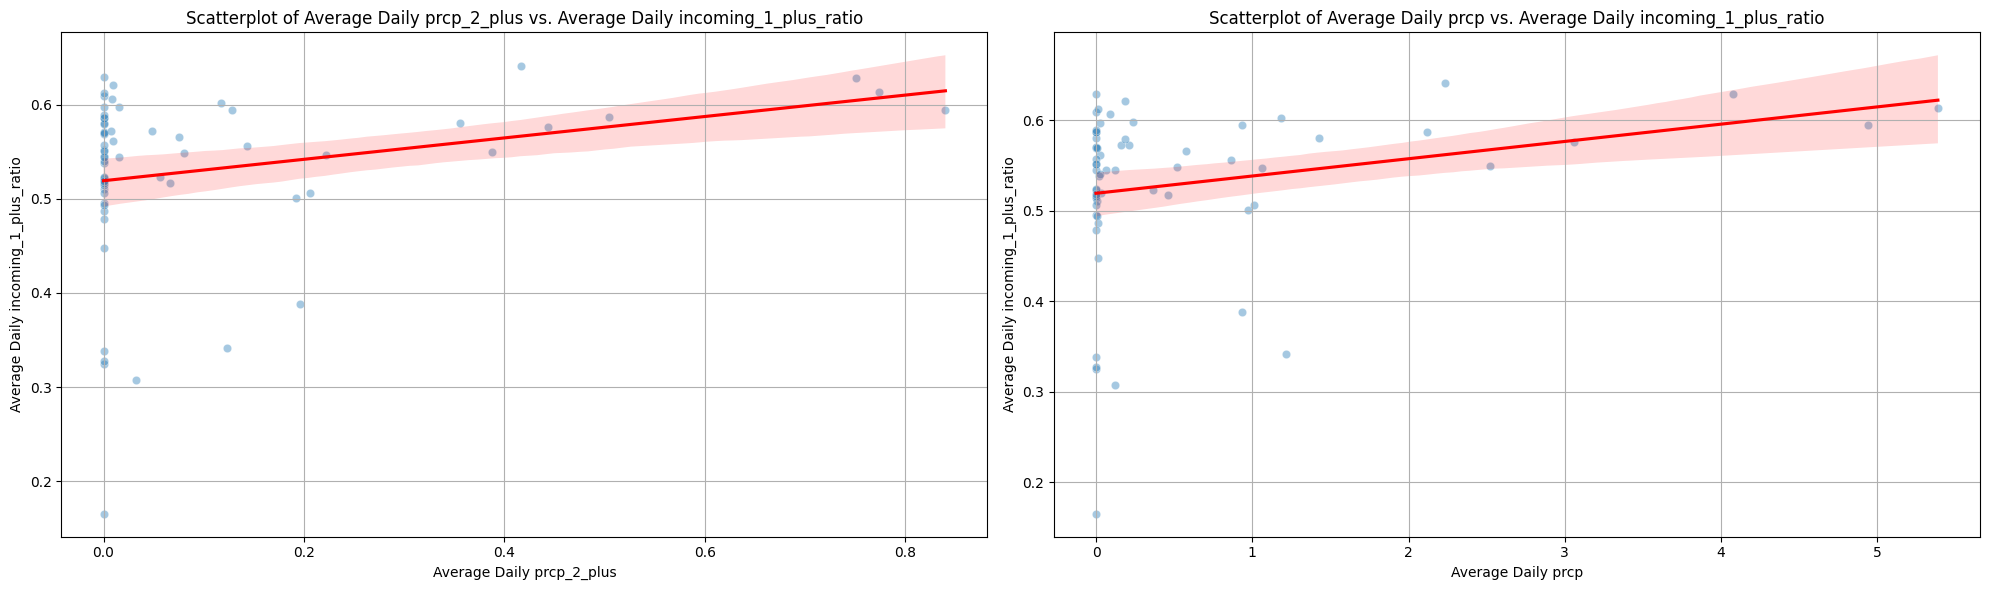

In [104]:
# Calculate daily averages for prcp_2_plus, prcp, and incoming_1_plus_ratio
daily_avg = (
    df.groupby(df["date"].dt.date)
    .agg(
        avg_prcp_2_plus=("prcp_2_plus", "mean"),
        avg_prcp=("prcp", "mean"),
        avg_incoming_1_plus_ratio=("incoming_1_plus_ratio", "mean"),
    )
    .reset_index()
)

# Create the scatterplots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Scatterplot for prcp_2_plus
sns.scatterplot(
    data=daily_avg,
    x="avg_prcp_2_plus",
    y="avg_incoming_1_plus_ratio",
    alpha=0.4,
    ax=axs[0],
)
sns.regplot(
    data=daily_avg,
    x="avg_prcp_2_plus",
    y="avg_incoming_1_plus_ratio",
    scatter=False,
    color="red",
    ax=axs[0],
)
axs[0].set_xlabel("Average Daily prcp_2_plus")
axs[0].set_ylabel("Average Daily incoming_1_plus_ratio")
axs[0].set_title(
    "Scatterplot of Average Daily prcp_2_plus vs. Average Daily incoming_1_plus_ratio"
)
axs[0].grid(True)

# Scatterplot for prcp
sns.scatterplot(
    data=daily_avg, x="avg_prcp", y="avg_incoming_1_plus_ratio", alpha=0.4, ax=axs[1]
)
sns.regplot(
    data=daily_avg,
    x="avg_prcp",
    y="avg_incoming_1_plus_ratio",
    scatter=False,
    color="red",
    ax=axs[1],
)
axs[1].set_xlabel("Average Daily prcp")
axs[1].set_ylabel("Average Daily incoming_1_plus_ratio")
axs[1].set_title(
    "Scatterplot of Average Daily prcp vs. Average Daily incoming_1_plus_ratio"
)
axs[1].grid(True)

plt.tight_layout()
plt.show()


If we look at the daily averages of the means of trains arriving with 1 minute delay to a certain stop, we can find a positive relationship. This corresponds to looking at the mere probability of delay, without gauging any size effects.
The takeaway from the above is, that we shall focus on the probability of train delays (or the ratio of their occurence to be more exact) instead of gauging the size of the delay.

In the following, we proceed to the analysis. We will not analyze the effect of other weather covariates, but we will keep an eye on the weighted betweenness measure as a possibly important graph feature.

I select the ratio of train delays on a given day as the outcome variable. Furthermore, I go with the continuous precipitation for the FD analysis, and the dummy variable indicating whether significant rain fell - with a somewhat arbitrary 2 mm cutoff - for the FE analysis.
A nice side-effect of our dependent variable being continuous between 0 and 1 is that we can more naturally apply first difference transformations making FD estimation feasible.

Before proceding however, we shall refresh what the distribution of the train delay probabilities looked like.

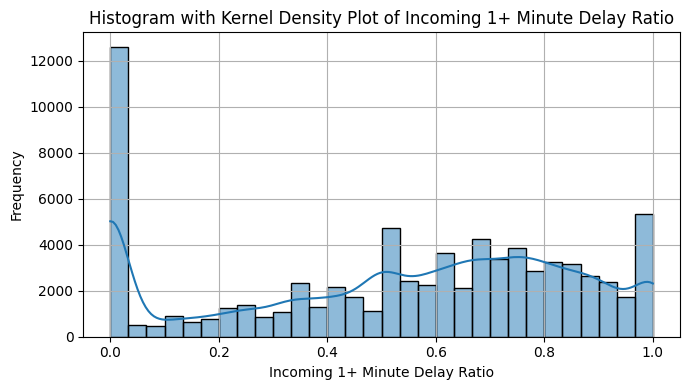

In [105]:
fig, ax = plt.subplots(figsize=(7, 4))

# Histogram with Kernel Density Plot for incoming_1_plus_ratio
sns.histplot(df["incoming_1_plus_ratio"], kde=True, bins=30, ax=ax)
ax.set_xlabel("Incoming 1+ Minute Delay Ratio")
ax.set_ylabel("Frequency")
ax.set_title("Histogram with Kernel Density Plot of Incoming 1+ Minute Delay Ratio")
ax.grid(True)

plt.tight_layout()
plt.show()


- we are dealing with a distribution, that has variance inbetween 0 and 1. 
- We could make a logistic OLS regression on a rainy day for robustness and heterogeneity analysis.

### Preparing the analysis

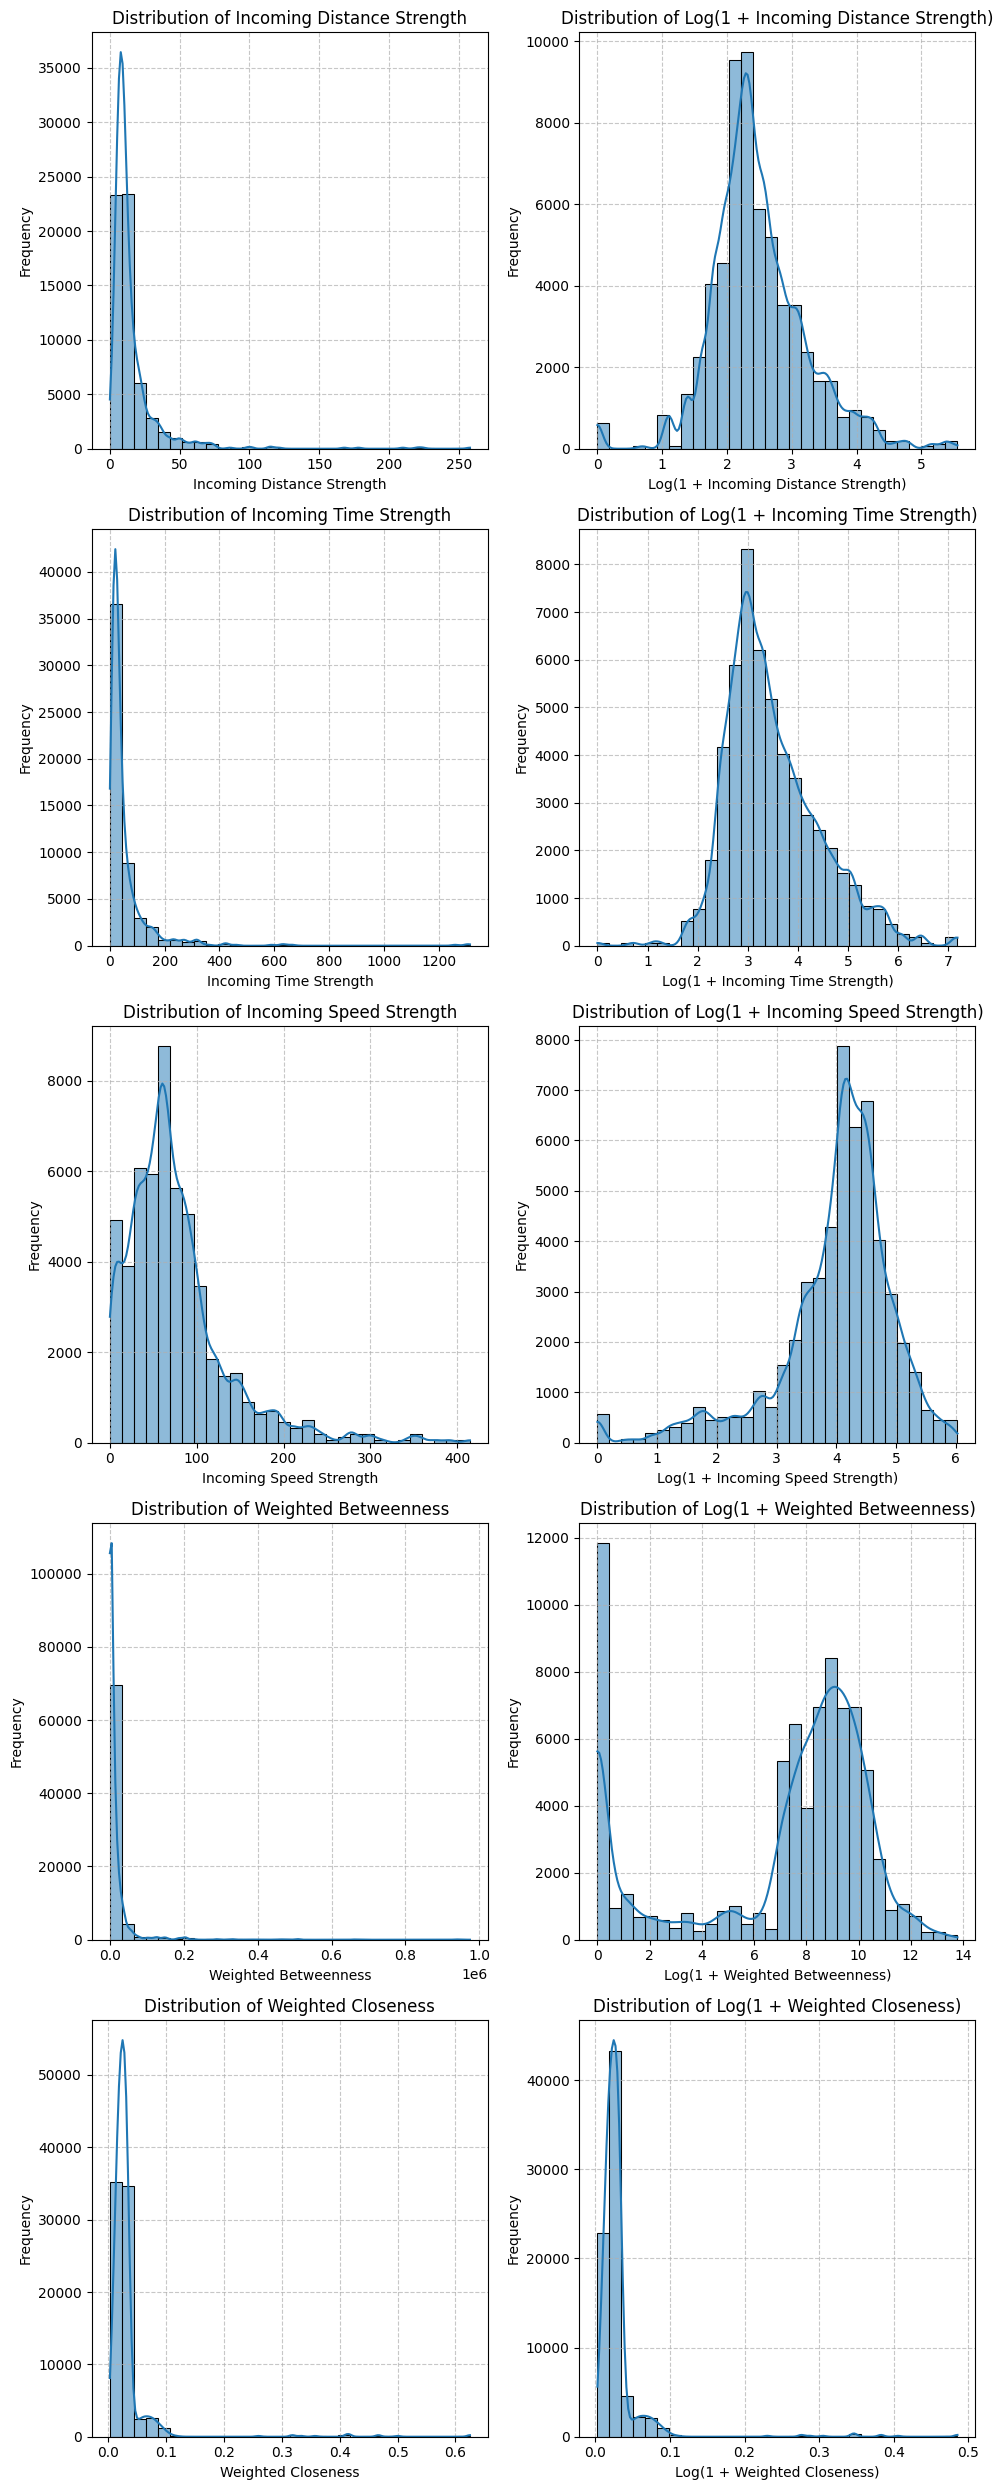

In [106]:
# Define the graph metrics
graph_metrics = [
    "incoming_distance_strength",
    "incoming_time_strength",
    "incoming_speed_strength",
    "weighted_betweenness",
    "weighted_closeness",
]

# Distribution of the 5 graph metrics and their log1p transformed pairs
fig, axs = plt.subplots(len(graph_metrics), 2, figsize=(10, 5 * len(graph_metrics)))

# Loop through each graph metric and create a histogram with KDE
for i, metric in enumerate(graph_metrics):
    # Original distribution
    sns.histplot(df[metric], kde=True, ax=axs[i, 0], bins=30)
    axs[i, 0].set_title(f"Distribution of {metric.replace('_', ' ').title()}")
    axs[i, 0].set_xlabel(metric.replace("_", " ").title())
    axs[i, 0].set_ylabel("Frequency")
    axs[i, 0].grid(True, linestyle="--", alpha=0.7)

    # Log1p transformed distribution
    sns.histplot(np.log1p(df[metric]), kde=True, ax=axs[i, 1], bins=30)
    axs[i, 1].set_title(f"Distribution of Log(1 + {metric.replace('_', ' ').title()})")
    axs[i, 1].set_xlabel(f"Log(1 + {metric.replace('_', ' ').title()})")
    axs[i, 1].set_ylabel("Frequency")
    axs[i, 1].grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [107]:
# creating the log of all the graph metrics
df["log_weighted_betweenness"] = np.log1p(df["weighted_betweenness"])
df["log_weighted_closeness"] = np.log1p(df["weighted_closeness"])
df["log_incoming_distance_strength"] = np.log1p(df["incoming_distance_strength"])
df["log_incoming_time_strength"] = np.log1p(df["incoming_time_strength"])
df["log_incoming_speed_strength"] = np.log1p(df["incoming_speed_strength"])


# Analysis

## First Differences

We prepare our analysis by creating the necessary variables for FD analysis

In [108]:
# Create a weekend dummy variable
df["is_weekend"] = df["date"].dt.dayofweek >= 5

# First-difference of variables within stop_id:
diff_vars = [
    # Delay ratios
    "incoming_1_plus_ratio",
    # Weather variables
    "prcp",
    "snow",
    "tavg",
    "tmin",
    "tmax",
    "wdir",
    "wspd",
    "wpgt",
    "pres",
    "tsun",
    # Graph metrics
    "log_weighted_betweenness",
    "log_weighted_closeness",
    "log_incoming_distance_strength",
    "log_incoming_time_strength",
    "log_incoming_speed_strength",
]

for var in diff_vars:
    df[f"d_{var}"] = df.groupby("stop_id")[var].diff()

# Create up to 6-period lags of prcp
for lag in range(1, 7):
    df[f"d_prcp_lag{lag}"] = df["d_prcp"].shift(lag)


REMOVED

After all the hope, we start off with being shot in the leg. The effect of change in precipitation is not present at all. This can be due to the way the underlying mechanism works: the baseline is, that no rain falls. If some rain falls, then it may in itself cause some delay for a stop. A decrease in rainfall is meaningless as an effect. Hence, we continue with Panel regression. However, before that, we introduce the confounder to have an expectation to the relationship for them.

INSTEAD

The difference in difference model relies on the assumption that on the day more rain falls, the ratio of trains arriving to a station with any number of minutes delayed is increasing. The model also assumes that a decrease in rainfall has a negative effect on delays, which in itself is not part of the effect mechanism, as we just simply return to the baseline given lower levels of rainfall. A Fixed Effects model is more suitable to explicitly analyze this relationship between baseline and extraordinary.

In [109]:
# Drop rows with any NaNs in the differenced columns used in the model
df_model1 = df[["d_incoming_1_plus_ratio", "d_prcp"]].dropna()

model1 = smf.ols(formula="d_incoming_1_plus_ratio ~ d_prcp", data=df_model1).fit()

print(model1.summary())

                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                  0.000
Method:                      Least Squares   F-statistic:                     37.65
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):           8.49e-10
Time:                             18:54:25   Log-Likelihood:                -592.14
No. Observations:                    75915   AIC:                             1188.
Df Residuals:                        75913   BIC:                             1207.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In

In [110]:
df_model2 = df[
    ["d_incoming_1_plus_ratio", "d_prcp", "d_log_weighted_betweenness"]
].dropna()

model2 = smf.ols(
    formula="d_incoming_1_plus_ratio ~ d_prcp + d_log_weighted_betweenness",
    data=df_model2,
).fit()

print(model2.summary())

                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.002
Model:                                 OLS   Adj. R-squared:                  0.002
Method:                      Least Squares   F-statistic:                     86.06
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):           4.62e-38
Time:                             18:54:26   Log-Likelihood:                -524.99
No. Observations:                    75915   AIC:                             1056.
Df Residuals:                        75912   BIC:                             1084.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [111]:
# Create the model with up to 2 lags
df_model3 = df[
    [
        "d_incoming_1_plus_ratio",
        "d_prcp",
        "d_prcp_lag1",
        "d_prcp_lag2",
        "d_log_weighted_betweenness",
    ]
].dropna()

model3 = smf.ols(
    formula="d_incoming_1_plus_ratio ~ d_prcp + d_prcp_lag1 + d_prcp_lag2 + d_log_weighted_betweenness",
    data=df_model3,
).fit()

print(model3.summary())

# Create the model with up to 6 lags
df_model_lag6 = df[
    [
        "d_incoming_1_plus_ratio",
        "d_prcp",
        "d_prcp_lag1",
        "d_prcp_lag2",
        "d_prcp_lag3",
        "d_prcp_lag4",
        "d_prcp_lag5",
        "d_prcp_lag6",
        "d_log_weighted_betweenness",
    ]
].dropna()

model_lag6 = smf.ols(
    formula="d_incoming_1_plus_ratio ~ d_prcp + d_prcp_lag1 + d_prcp_lag2 + d_prcp_lag3 + d_prcp_lag4 + d_prcp_lag5 + d_prcp_lag6 + d_log_weighted_betweenness",
    data=df_model_lag6,
).fit()

print(model_lag6.summary())

                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.002
Model:                                 OLS   Adj. R-squared:                  0.002
Method:                      Least Squares   F-statistic:                     43.07
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):           3.75e-36
Time:                             18:54:26   Log-Likelihood:                -525.77
No. Observations:                    75913   AIC:                             1062.
Df Residuals:                        75908   BIC:                             1108.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------


                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.002
Model:                                 OLS   Adj. R-squared:                  0.002
Method:                      Least Squares   F-statistic:                     21.98
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):           8.58e-34
Time:                             18:54:26   Log-Likelihood:                -523.77
No. Observations:                    75909   AIC:                             1066.
Df Residuals:                        75900   BIC:                             1149.
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

Adding lags even for two periods corroborates our assumption, that yesterday's rainfall does not have an effect on today's delays. We see the same hold when we add 6 periods. The cumulative effect remains significant, but is not different to the contemporaneous effect.

In [112]:
# For K = 2
df_model_lag2b = df[
    [
        "d_incoming_1_plus_ratio",
        "d_prcp",
        "d_prcp_lag1",
        "d_prcp_lag2",
        "d_log_weighted_betweenness",
    ]
].dropna()

df_model_lag2b["cumulative_effect_lag2"] = df["d_prcp_lag2"]

# Create the "delta" variables representing the differences in differences
df_model_lag2b["delta0"] = df_model_lag2b["d_prcp"] - df_model_lag2b["d_prcp_lag1"]
df_model_lag2b["delta1"] = df_model_lag2b["d_prcp_lag1"] - df_model_lag2b["d_prcp_lag2"]

# Now, the model reparameterized so that the coefficient on d_prcp_lag2 is the cumulative effect
model3b = smf.ols(
    formula="d_incoming_1_plus_ratio ~ cumulative_effect_lag2 + delta0 + delta1 + d_log_weighted_betweenness",
    data=df_model_lag2b,
).fit()

print(model3b.summary())


                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.002
Model:                                 OLS   Adj. R-squared:                  0.002
Method:                      Least Squares   F-statistic:                     43.07
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):           3.75e-36
Time:                             18:54:26   Log-Likelihood:                -525.77
No. Observations:                    75913   AIC:                             1062.
Df Residuals:                        75908   BIC:                             1108.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [113]:
# For K = 6
df_model_lag6b = df[
    [
        "d_incoming_1_plus_ratio",
        "d_prcp",
        "d_prcp_lag1",
        "d_prcp_lag2",
        "d_prcp_lag3",
        "d_prcp_lag4",
        "d_prcp_lag5",
        "d_prcp_lag6",
        "d_log_weighted_betweenness",
    ]
].dropna()

df_model_lag6b["cumulative_effect_lag6"] = df["d_prcp_lag6"]

# Create the "delta" variables representing the differences between successive lags
df_model_lag6b["delta0"] = df_model_lag6b["d_prcp"] - df_model_lag6b["d_prcp_lag1"]
df_model_lag6b["delta1"] = df_model_lag6b["d_prcp_lag1"] - df_model_lag6b["d_prcp_lag2"]
df_model_lag6b["delta2"] = df_model_lag6b["d_prcp_lag2"] - df_model_lag6b["d_prcp_lag3"]
df_model_lag6b["delta3"] = df_model_lag6b["d_prcp_lag3"] - df_model_lag6b["d_prcp_lag4"]
df_model_lag6b["delta4"] = df_model_lag6b["d_prcp_lag4"] - df_model_lag6b["d_prcp_lag5"]
df_model_lag6b["delta5"] = df_model_lag6b["d_prcp_lag5"] - df_model_lag6b["d_prcp_lag6"]

# Reparameterized model with the cumulative effect directly estimated as the coefficient on d_prcp_lag6
model_lag6b = smf.ols(
    formula=(
        "d_incoming_1_plus_ratio ~ cumulative_effect_lag6 + delta0 + delta1 + delta2 + "
        "delta3 + delta4 + delta5 + d_log_weighted_betweenness"
    ),
    data=df_model_lag6b,
).fit()

print(model_lag6b.summary())


                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.002
Model:                                 OLS   Adj. R-squared:                  0.002
Method:                      Least Squares   F-statistic:                     21.98
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):           8.58e-34
Time:                             18:54:26   Log-Likelihood:                -523.77
No. Observations:                    75909   AIC:                             1066.
Df Residuals:                        75900   BIC:                             1149.
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [114]:
# Create a weekend dummy variable
df["is_weekend"] = df["date"].dt.dayofweek >= 5

# Model 4: Including Weekend Dummies
df_model4 = df[
    [
        "d_incoming_1_plus_ratio",
        "d_prcp",
        "d_prcp_lag1",
        "d_log_weighted_betweenness",
        "is_weekend",
    ]
].dropna()

model4 = smf.ols(
    formula="d_incoming_1_plus_ratio ~ d_prcp + d_prcp_lag1 + d_log_weighted_betweenness + is_weekend",
    data=df_model4,
).fit()

print(model4.summary())

# Model 5: Including Time Period Fixed Effects

# Model 5: Including Time Period Fixed Effects
df_model5 = df[
    [
        "d_incoming_1_plus_ratio",
        "d_prcp",
        "d_prcp_lag1",
        "d_log_weighted_betweenness",
        "date",
    ]
].dropna()

model5 = smf.ols(
    formula="d_incoming_1_plus_ratio ~ d_prcp + d_prcp_lag1 + d_log_weighted_betweenness + C(date)",
    data=df_model5,
).fit()

print(model5.summary())

                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.009
Model:                                 OLS   Adj. R-squared:                  0.009
Method:                      Least Squares   F-statistic:                     182.0
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):          1.79e-155
Time:                             18:54:26   Log-Likelihood:                -249.18
No. Observations:                    75914   AIC:                             508.4
Df Residuals:                        75909   BIC:                             554.6
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [115]:
# Model 6: Including snow and other weather variables, but removing time fixed effects
df_model6 = df[
    [
        "d_incoming_1_plus_ratio",
        "d_prcp",
        "d_prcp_lag1",
        "d_log_weighted_betweenness",
        "any_snow",
        "tavg",
        "tmin",
        "tmax",
        "wdir",
        "wspd",
        "wpgt",
        "pres",
    ]
].dropna()

# Difference of weather variables
for col in ["tavg", "tmin", "tmax", "wdir", "wspd", "wpgt", "pres"]:
    df_model6[f"d_{col}"] = df.groupby("stop_id")[col].diff()

model6 = smf.ols(
    formula="d_incoming_1_plus_ratio ~ d_prcp + d_prcp_lag1 + d_log_weighted_betweenness + C(any_snow) + d_tavg + d_tmin + d_tmax + d_wdir + d_wspd + d_wpgt + d_pres",
    data=df_model6,
).fit()

print(model6.summary())

                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.007
Model:                                 OLS   Adj. R-squared:                  0.006
Method:                      Least Squares   F-statistic:                     45.95
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):          4.91e-101
Time:                             18:54:28   Log-Likelihood:                -359.48
No. Observations:                    75914   AIC:                             743.0
Df Residuals:                        75902   BIC:                             853.8
Df Model:                               11                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [116]:
list(df.columns)

['stop_id',
 'stop_name',
 'stop_lat',
 'stop_lon',
 'num_incoming_edges',
 'num_outgoing_edges',
 'incoming',
 'outgoing',
 'sum_incoming_outgoing',
 'incoming_1_plus',
 'outgoing_1_plus',
 'sum_incoming_outgoing_1_plus',
 'incoming_15_plus',
 'outgoing_15_plus',
 'sum_incoming_outgoing_15_plus',
 'incoming_30_plus',
 'outgoing_30_plus',
 'sum_incoming_outgoing_30_plus',
 'incoming_60_plus',
 'outgoing_60_plus',
 'sum_incoming_outgoing_60_plus',
 'incoming_120_plus',
 'outgoing_120_plus',
 'sum_incoming_outgoing_120_plus',
 'avg_neighboring_delay',
 'avg_incoming_delay',
 'weighted_betweenness',
 'betweenness',
 'weighted_closeness',
 'closeness',
 'weighted_betweenness_1_plus',
 'weighted_closeness_1_plus',
 'weighted_betweenness_15_plus',
 'weighted_closeness_15_plus',
 'weighted_betweenness_30_plus',
 'weighted_closeness_30_plus',
 'weighted_betweenness_60_plus',
 'weighted_closeness_60_plus',
 'weighted_betweenness_120_plus',
 'weighted_closeness_120_plus',
 'day_of_week',
 'incom

In [117]:
# "log_weighted_betweenness",
# "log_weighted_closeness",
# "incoming_distance_strength",
# "incoming_time_strength",
# "incoming_speed_strength",

# Model 7: Including graph-related confounders, but removing time fixed effects and weather confounders
df_model7 = df[
    [
        "d_incoming_1_plus_ratio",
        "d_prcp",
        "d_prcp_lag1",
        "d_log_weighted_betweenness",
        "d_log_weighted_closeness",
        "log_incoming_distance_strength",
        "log_incoming_time_strength",
        "log_incoming_speed_strength",
    ]
].dropna()

model7 = smf.ols(
    formula="d_incoming_1_plus_ratio ~ d_prcp + d_prcp_lag1 + d_log_weighted_betweenness + d_log_weighted_closeness + log_incoming_distance_strength + log_incoming_time_strength + log_incoming_speed_strength",
    data=df_model7,
).fit()

print(model7.summary())


                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.109
Model:                                 OLS   Adj. R-squared:                  0.108
Method:                      Least Squares   F-statistic:                     915.3
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):               0.00
Time:                             18:54:28   Log-Likelihood:                 2876.2
No. Observations:                    52604   AIC:                            -5736.
Df Residuals:                        52596   BIC:                            -5665.
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [118]:
from stargazer.stargazer import Stargazer

# Assign models to Stargazer
stargazer_fd = Stargazer([model1, model2, model3, model4, model5, model6, model7])

# Customize Stargazer output
stargazer_fd.title("Fixed Differences Models")
stargazer_fd.custom_columns(
    [
        "Baseline",
        "Graph Measure",
        "Up to 2 Lags",
        "Weekend",
        "Time Fixed Effects",
        "Weather Confounders",
        "Graph Confounders",
    ],
    [1, 1, 1, 1, 1, 1, 1],
)

# Add lines for model characteristics
stargazer_fd.add_line("Time Fixed Effects", ["No", "No", "No", "No", "Yes", "No", "No"])
stargazer_fd.add_line(
    "Weather Confounders", ["No", "No", "No", "No", "No", "Yes", "No"]
)

# Define covariate order (excluding omitted variables)
stargazer_fd.covariate_order(
    [
        "Intercept",
        "d_prcp",
        "d_prcp_lag1",
        "d_prcp_lag2",
        "d_log_weighted_betweenness",
        "d_log_weighted_closeness",
        "log_incoming_distance_strength",
        "log_incoming_time_strength",
        "log_incoming_speed_strength",
        "is_weekend[T.True]",
    ]
)

# Rename covariates for clarity
stargazer_fd.rename_covariates(
    {
        "Intercept": "Intercept",
        "d_prcp": "Δ Precipitation (t=0)",
        "d_prcp_lag1": "Δ Precipitation (1-Day Lag)",
        "d_prcp_lag2": "Δ Precipitation (2-Day Lag)",
        "d_log_weighted_betweenness": "Δ Weighted Betweenness",
        "d_log_weighted_closeness": "Δ Weighted Closeness",
        "log_incoming_distance_strength": "Log Incoming Distance Strength",
        "log_incoming_time_strength": "Log Incoming Time Strength",
        "log_incoming_speed_strength": "Log Incoming Speed Strength",
        "is_weekend[T.True]": "Weekend Dummy",
    }
)

# Define dependent variable name
stargazer_fd.dependent_variable_name("Δ Incoming Trains (≥1 min late)")

# Hide model numbers
stargazer_fd.show_model_numbers(False)

# Save table as an HTML file
with open("fixed_differences_models.html", "w", encoding="utf-8") as f:
    f.write(stargazer_fd.render_html())

# Display Stargazer object
stargazer_fd


### Summary

In our first FD model, we estimated delay ratio against precipitation. Then, we added our main confounder

## Fixed Effects - robustness analysis

Fixed Effect models average out the differences (...)
- Coefficients are understood as the effect of a unit difference on a given day at a certain stop relative to the feature's respective average on the dependent variable's difference from it's respective average (over the same unit and time section).
- This takes off some emphasis on immediate effects and puts more emphasis on general covariance conditional on many things.
- Also, the output is not intrinsically made symmetric with the differentiation, hence worse fit with a linear estimation.
- Hence, possibly weaker effect measured

In [126]:
df.set_index(["date", "stop_id"], inplace=True)
df = df.sort_index()

In [128]:
# same variables as model 6, but instead of differencing, we will use the original values
df_model8 = df[
    [
        "incoming_1_plus_ratio",
        "prcp",
        "log_weighted_betweenness",
        "any_snow",
        "tavg",
        "tmin",
        "tmax",
        "wdir",
        "wspd",
        "wpgt",
        "pres",
    ]
]

model8 = PanelOLS.from_formula(
    "incoming_1_plus_ratio ~ prcp + log_weighted_betweenness +"
    # "any_snow + tavg + tmin + tmax + wdir + wspd + wpgt + pres +"
    "EntityEffects + TimeEffects",
    data=df_model8,
)

results8 = model8.fit(cov_type="clustered", cluster_entity=True)

print(results8)

                            PanelOLS Estimation Summary                            
Dep. Variable:     incoming_1_plus_ratio   R-squared:                        0.0004
Estimator:                      PanelOLS   R-squared (Between):             -0.0999
No. Observations:                  77120   R-squared (Within):              -0.0009
Date:                   Sat, Mar 01 2025   R-squared (Overall):             -0.0753
Time:                           19:50:56   Log-likelihood                  3.01e+04
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      16.085
Entities:                             64   P-value                           0.0000
Avg Obs:                          1205.0   Distribution:                 F(2,75850)
Min Obs:                          1205.0                                           
Max Obs:                          1205.0   F-statistic (robust):            

## Homogeneity - First Differences 
- looking at Christmas festivities' month (dec 12 - jan 12), and then looking jan-feb (jan13-feb13)

In [121]:
df.reset_index(inplace=True)


In [122]:
# Filter the dataframe for the specified time period
df_christmas = df[df["date"] <= "2025-01-12"]

# Define the model variables
model_vars = [
    "date",
    "stop_id",
    "d_incoming_1_plus_ratio",
    "d_prcp",
    "d_prcp_lag1",
    "d_log_weighted_betweenness",
    "any_snow",
    "tavg",
    "tmin",
    "tmax",
    "wdir",
    "wspd",
    "wpgt",
    "pres",
]

# Filter the dataframe to include only the necessary columns and drop NaNs
df_christmas = df_christmas[model_vars].dropna()

# Difference of weather variables
for col in ["tavg", "tmin", "tmax", "wdir", "wspd", "wpgt", "pres"]:
    df_christmas[f"d_{col}"] = df_christmas.groupby("stop_id")[col].diff()

# Fit the model
model6_christmas = smf.ols(
    formula="d_incoming_1_plus_ratio ~ d_prcp + d_prcp_lag1 + d_log_weighted_betweenness + C(any_snow) + d_tavg + d_tmin + d_tmax + d_wdir + d_wspd + d_wpgt + d_pres",
    data=df_christmas,
).fit()

# Print the summary
print(model6_christmas.summary())

                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.006
Model:                                 OLS   Adj. R-squared:                  0.006
Method:                      Least Squares   F-statistic:                     19.42
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):           1.50e-39
Time:                             18:54:30   Log-Likelihood:                 1314.1
No. Observations:                    36149   AIC:                            -2604.
Df Residuals:                        36137   BIC:                            -2502.
Df Model:                               11                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [123]:
# Filter the dataframe for the specified time period
df_after_christmas = df[df["date"] >= "2025-01-13"]

# Define the model variables
model_vars = [
    "date",
    "stop_id",
    "d_incoming_1_plus_ratio",
    "d_prcp",
    "d_prcp_lag1",
    "d_log_weighted_betweenness",
    "any_snow",
    "tavg",
    "tmin",
    "tmax",
    "wdir",
    "wspd",
    "wpgt",
    "pres",
]

# Filter the dataframe to include only the necessary columns and drop NaNs
df_after_christmas = df_after_christmas[model_vars].dropna()

# Difference of weather variables
for col in ["tavg", "tmin", "tmax", "wdir", "wspd", "wpgt", "pres"]:
    df_after_christmas[f"d_{col}"] = df_after_christmas.groupby("stop_id")[col].diff()

# Fit the model
model6_after_christmas = smf.ols(
    formula="d_incoming_1_plus_ratio ~ d_prcp + d_prcp_lag1 + d_log_weighted_betweenness + C(any_snow) + d_tavg + d_tmin + d_tmax + d_wdir + d_wspd + d_wpgt + d_pres",
    data=df_after_christmas,
).fit()

# Print the summary
print(model6_after_christmas.summary())

                               OLS Regression Results                              
Dep. Variable:     d_incoming_1_plus_ratio   R-squared:                       0.020
Model:                                 OLS   Adj. R-squared:                  0.020
Method:                      Least Squares   F-statistic:                     68.81
Date:                     Sat, 01 Mar 2025   Prob (F-statistic):          1.38e-153
Time:                             18:54:31   Log-Likelihood:                 659.52
No. Observations:                    37355   AIC:                            -1295.
Df Residuals:                        37343   BIC:                            -1193.
Df Model:                               11                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [124]:
from stargazer.stargazer import Stargazer

# Assign models to Stargazer
stargazer_christmas = Stargazer([model6_christmas, model6_after_christmas])

# Customize Stargazer output
stargazer_christmas.title("Fixed Differences Models - Christmas and After Christmas")
stargazer_christmas.custom_columns(
    ["Christmas Period", "After Christmas Period"],
    [1, 1],
)

# Add lines for model characteristics
stargazer_christmas.add_line("Time Fixed Effects", ["No", "No"])
stargazer_christmas.add_line("Weather Confounders", ["Yes", "Yes"])

# Define covariate order (excluding omitted variables)
stargazer_christmas.covariate_order(
    [
        "Intercept",
        "d_prcp",
        "d_prcp_lag1",
        "d_log_weighted_betweenness",
        "C(any_snow)[T.True]",
        "d_tavg",
        "d_tmin",
        "d_tmax",
        "d_wdir",
        "d_wspd",
        "d_wpgt",
        "d_pres",
    ]
)

# Rename covariates for clarity
stargazer_christmas.rename_covariates(
    {
        "Intercept": "Intercept",
        "d_prcp": "Δ Precipitation (t=0)",
        "d_prcp_lag1": "Δ Precipitation (1-Day Lag)",
        "d_log_weighted_betweenness": "Δ Weighted Betweenness",
        "C(any_snow)[T.True]": "Snow Dummy",
        "d_tavg": "Δ Average Temperature",
        "d_tmin": "Δ Minimum Temperature",
        "d_tmax": "Δ Maximum Temperature",
        "d_wdir": "Δ Wind Direction",
        "d_wspd": "Δ Wind Speed",
        "d_wpgt": "Δ Wind Gust",
        "d_pres": "Δ Pressure",
    }
)

# Define dependent variable name
stargazer_christmas.dependent_variable_name("Δ Incoming Trains (≥1 min late)")

# Hide model numbers
stargazer_christmas.show_model_numbers(False)

# # Save table as an HTML file
# with open("fixed_differences_models_christmas.html", "w", encoding="utf-8") as f:
#     f.write(stargazer_christmas.render_html())

# Display Stargazer object
stargazer_christmas